## 1. 环境准备与数据加载

In [1]:
# 导入基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 导入机器学习库
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline

# 设置随机种子
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

print('✓ 环境配置完成')

✓ 环境配置完成


In [2]:
# 加载数据 - 使用Kaggle Hub
import os

csv_file = 'california_housing.csv'

# 如果本地没有文件，使用kagglehub下载
if not os.path.exists(csv_file):
    print('本地文件不存在，使用Kaggle Hub下载...')
    
    try:
        # 安装kagglehub（如果未安装）
        try:
            import kagglehub
            from kagglehub import KaggleDatasetAdapter
        except ImportError:
            print('安装 kagglehub...')
            import subprocess
            subprocess.check_call(['pip', 'install', 'kagglehub[pandas-datasets]', '-q'])
            import kagglehub
            from kagglehub import KaggleDatasetAdapter
        
        print('正在从Kaggle下载数据集...')
        
        # 下载数据
        df_raw = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "camnugent/california-housing-prices",
            "housing.csv"
        )
        
        # 保存到本地
        df_raw.to_csv(csv_file, index=False)
        print(f'✓ 下载成功并保存到: {csv_file}')
        
    except Exception as e:
        print(f'Kaggle Hub下载失败: {e}')
        print('\n请手动下载：')
        print('1. 访问: https://www.kaggle.com/datasets/camnugent/california-housing-prices')
        print('2. 下载 housing.csv')
        print(f'3. 重命名为 {csv_file} 并放到当前目录')
        raise Exception('无法自动下载数据，请手动下载')
else:
    print(f'✓ 使用本地文件: {csv_file}')

# 读取本地CSV文件
df_raw = pd.read_csv(csv_file)

print(f'\n原始数据形状: {df_raw.shape}')
print(f'原始数据列: {list(df_raw.columns)}')

# 转换为sklearn格式（8个特征）
df_processed = pd.DataFrame()
df_processed['MedInc'] = df_raw['median_income']
df_processed['HouseAge'] = df_raw['housing_median_age']
df_processed['AveRooms'] = df_raw['total_rooms'] / df_raw['households']
df_processed['AveBedrms'] = df_raw['total_bedrooms'] / df_raw['households']
df_processed['Population'] = df_raw['population']
df_processed['AveOccup'] = df_raw['population'] / df_raw['households']
df_processed['Latitude'] = df_raw['latitude']
df_processed['Longitude'] = df_raw['longitude']
df_processed['MedHouseVal'] = df_raw['median_house_value'] / 100000.0  # 转为10万美元单位

# 处理缺失值
print(f'\n缺失值数量: {df_processed.isnull().sum().sum()}')
df = df_processed.dropna()
print(f'删除缺失值后: {df.shape}')

# 构造sklearn兼容对象
from sklearn.utils import Bunch
california = Bunch(
    data=df.iloc[:, :-1].values,
    target=df.iloc[:, -1].values,
    feature_names=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                   'Population', 'AveOccup', 'Latitude', 'Longitude']
)

print(f'\n✓ 数据加载完成')
print(f'数据集形状: {df.shape}')
print(f'特征数量: {len(california.feature_names)}')
print(f'样本数量: {len(df)}')
print('\n特征列表:', california.feature_names)
print('\n数据集前5行:')
df.head()

✓ 使用本地文件: california_housing.csv

原始数据形状: (20640, 10)
原始数据列: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

缺失值数量: 207
删除缺失值后: (20433, 9)

✓ 数据加载完成
数据集形状: (20433, 9)
特征数量: 8
样本数量: 20433

特征列表: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

数据集前5行:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


---
## 2. 数据探索与可视化 (EDA)

EDA是数据科学项目最重要的步骤，帮助我们：
- 理解数据分布
- 发现异常值
- 找出特征之间的关系
- 为特征工程提供灵感

### 2.1 基本统计信息

In [3]:
# 数据基本信息
print('=== 数据基本信息 ===')
df.info()

print('\n=== 缺失值统计 ===')
print(df.isnull().sum())

print('\n=== 统计描述 ===')
df.describe()

=== 数据基本信息 ===
<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20433 non-null  float64
 1   HouseAge     20433 non-null  float64
 2   AveRooms     20433 non-null  float64
 3   AveBedrms    20433 non-null  float64
 4   Population   20433 non-null  float64
 5   AveOccup     20433 non-null  float64
 6   Latitude     20433 non-null  float64
 7   Longitude    20433 non-null  float64
 8   MedHouseVal  20433 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB

=== 缺失值统计 ===
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

=== 统计描述 ===


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,3.871162,28.633094,5.431344,1.097062,1424.946949,3.071533,35.633221,-119.570689,2.068644
std,1.899291,12.591805,2.482946,0.476104,1133.208490,10.438269,2.136348,2.003578,1.154357
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563700,18.000000,4.441441,1.006029,787.000000,2.429032,33.930000,-121.800000,1.195000
50%,3.536500,29.000000,5.230769,1.048889,1166.000000,2.817582,34.260000,-118.490000,1.797000
75%,4.744000,37.000000,6.052381,1.099631,1722.000000,3.281513,37.720000,-118.010000,2.647000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### 2.2 目标变量分布

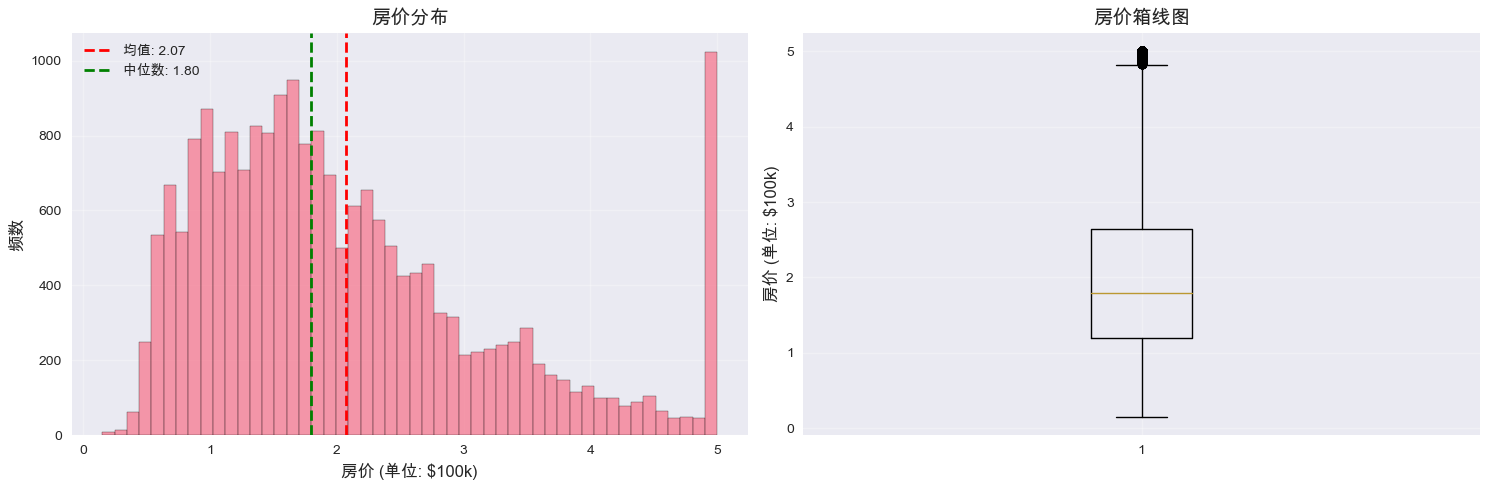

房价偏度 (Skewness): 0.9783
房价峰度 (Kurtosis): 0.3280

注意: 房价分布右偏，存在高价房异常值，最大值被截断为5.0


In [4]:
# 房价分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 直方图
axes[0].hist(df['MedHouseVal'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['MedHouseVal'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'均值: {df["MedHouseVal"].mean():.2f}')
axes[0].axvline(df['MedHouseVal'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'中位数: {df["MedHouseVal"].median():.2f}')
axes[0].set_xlabel('房价 (单位: $100k)', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('房价分布', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 箱线图
axes[1].boxplot(df['MedHouseVal'], vert=True)
axes[1].set_ylabel('房价 (单位: $100k)', fontsize=12)
axes[1].set_title('房价箱线图', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 偏度和峰度
print(f'房价偏度 (Skewness): {df["MedHouseVal"].skew():.4f}')
print(f'房价峰度 (Kurtosis): {df["MedHouseVal"].kurtosis():.4f}')
print('\n注意: 房价分布右偏，存在高价房异常值，最大值被截断为5.0')

### 2.3 特征分布

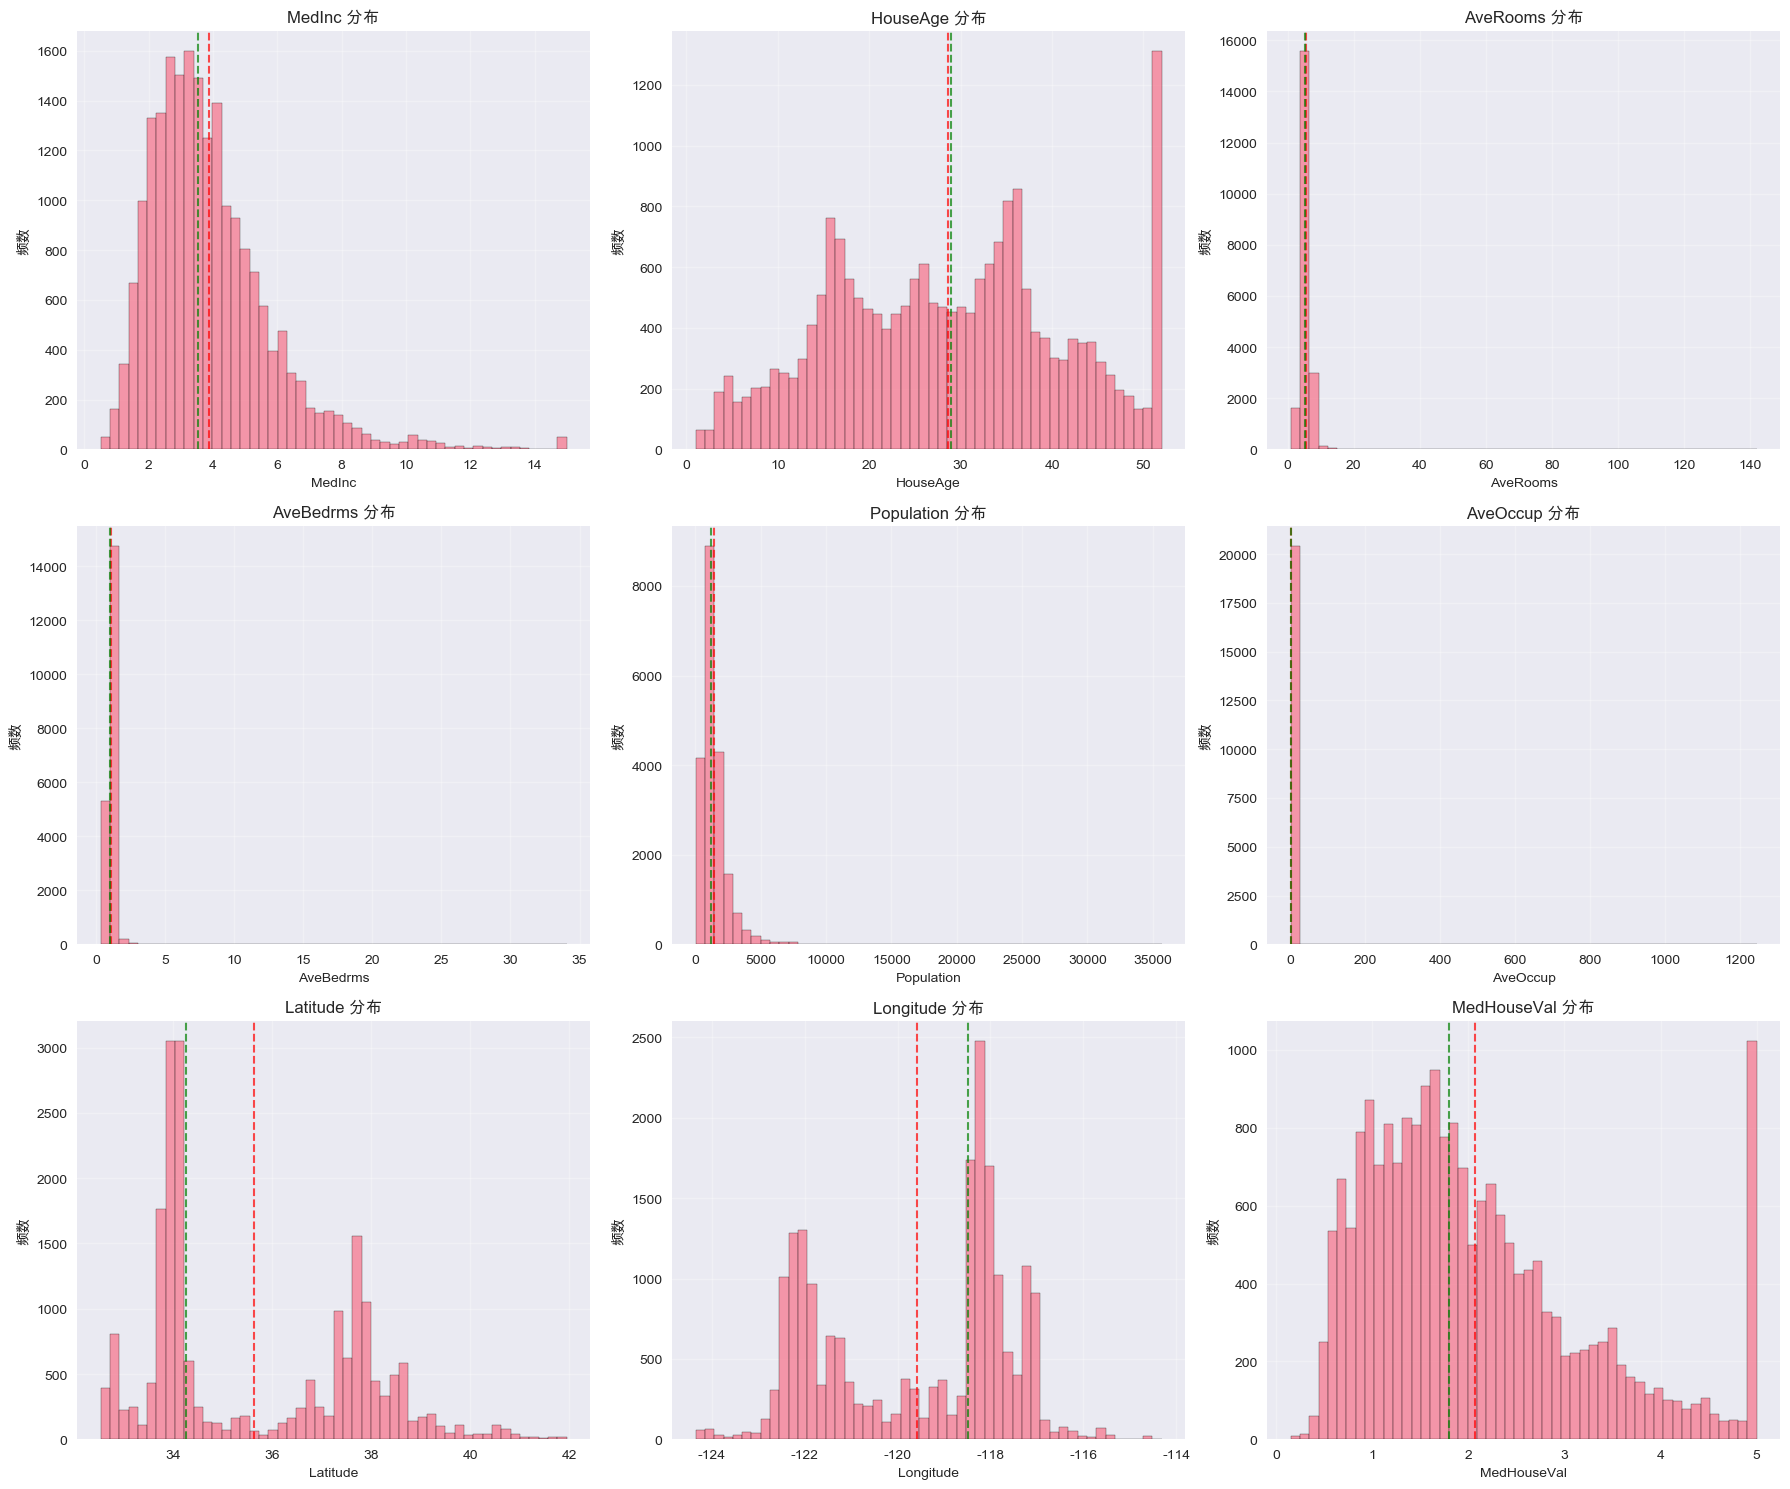


=== 图例说明 ===
红色虚线 = 均值 (Mean) | 绿色虚线 = 中位数 (Median)
💡 如果均值>>中位数 → 右偏分布（存在极端大值拉高均值）
💡 如果均值≈中位数 → 对称分布

=== 各特征分布分析 ===

【MedInc】
  均值: 3.87 | 中位数: 3.54 | 偏度: 1.64
  → 接近正态分布（钟形，左右对称）

【HouseAge】
  均值: 28.63 | 中位数: 29.00 | 偏度: 0.06
  → 多峰分布，52年处有截断峰（最大值52被人为限制）

【AveRooms】
  均值: 5.43 | 中位数: 5.23 | 偏度: 20.68
  → 极端右偏！99%数据≤10.37，但最大值141.91（需处理）

【AveBedrms】
  均值: 1.10 | 中位数: 1.05 | 偏度: 31.20
  → 极端右偏！99%数据≤2.14，但最大值34.07（需处理）

【Population】
  均值: 1424.95 | 中位数: 1166.00 | 偏度: 4.96
  → 严重右偏，99%数据≤5809.04，最大值35682.00（长尾）

【AveOccup】
  均值: 3.07 | 中位数: 2.82 | 偏度: 97.16
  → 极端右偏！99%数据≤5.40，但最大值1243.33（需处理）

【Latitude】
  均值: 35.63 | 中位数: 34.26 | 偏度: 0.46
  → 多峰分布（反映城市地理聚集）

【Longitude】
  均值: -119.57 | 中位数: -118.49 | 偏度: -0.30
  → 多峰分布（反映城市地理聚集）

【MedHouseVal】
  均值: 2.07 | 中位数: 1.80 | 偏度: 0.98


=== 关键发现 ===
✅ 正态分布: MedInc（适合直接建模）
⚠️  轻微右偏: HouseAge, MedHouseVal（可接受）
🔴 严重右偏: AveRooms, AveBedrms, Population, AveOccup
   → 这些特征需要处理：对数变换 或 异常值截断

📊 如何读直方图:
  1. 看形状: 钟形=好, L形=右偏需处理
  2. 看红绿线: 重合=对称, 

In [5]:
# 绘制所有特征的分布
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} 分布', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('频数', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # 添加统计信息
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.7, linewidth=1.5)

plt.tight_layout()
plt.show()

# 改进后的观察说明
print('\n=== 图例说明 ===')
print('红色虚线 = 均值 (Mean) | 绿色虚线 = 中位数 (Median)')
print('💡 如果均值>>中位数 → 右偏分布（存在极端大值拉高均值）')
print('💡 如果均值≈中位数 → 对称分布\n')

print('=== 各特征分布分析 ===\n')

# 逐个分析每个特征
for col in df.columns:
    mean_val = df[col].mean()
    median_val = df[col].median()
    skewness = df[col].skew()
    q99 = df[col].quantile(0.99)
    max_val = df[col].max()
    
    print(f'【{col}】')
    print(f'  均值: {mean_val:.2f} | 中位数: {median_val:.2f} | 偏度: {skewness:.2f}')
    
    # 根据偏度和实际数据判断分布类型
    if col == 'HouseAge':
        print(f'  → 多峰分布，52年处有截断峰（最大值{max_val:.0f}被人为限制）')
    elif col in ['MedInc']:
        print(f'  → 接近正态分布（钟形，左右对称）')
    elif col in ['Latitude', 'Longitude']:
        print(f'  → 多峰分布（反映城市地理聚集）')
    elif skewness > 10:
        print(f'  → 极端右偏！99%数据≤{q99:.2f}，但最大值{max_val:.2f}（需处理）')
    elif skewness > 2:
        print(f'  → 严重右偏，99%数据≤{q99:.2f}，最大值{max_val:.2f}（长尾）')
    elif skewness > 1:
        print(f'  → 轻微右偏')
    elif abs(skewness) < 0.5:
        print(f'  → 接近对称分布')
    
    print()

print('\n=== 关键发现 ===')
print('✅ 正态分布: MedInc（适合直接建模）')
print('⚠️  轻微右偏: HouseAge, MedHouseVal（可接受）')
print('🔴 严重右偏: AveRooms, AveBedrms, Population, AveOccup')
print('   → 这些特征需要处理：对数变换 或 异常值截断')
print('\n📊 如何读直方图:')
print('  1. 看形状: 钟形=好, L形=右偏需处理')
print('  2. 看红绿线: 重合=对称, 红线>>绿线=被极端值拉高')
print('  3. 看X轴: 如果大部分数据挤在左边10%区域 = 严重长尾')

### 2.4 相关性分析

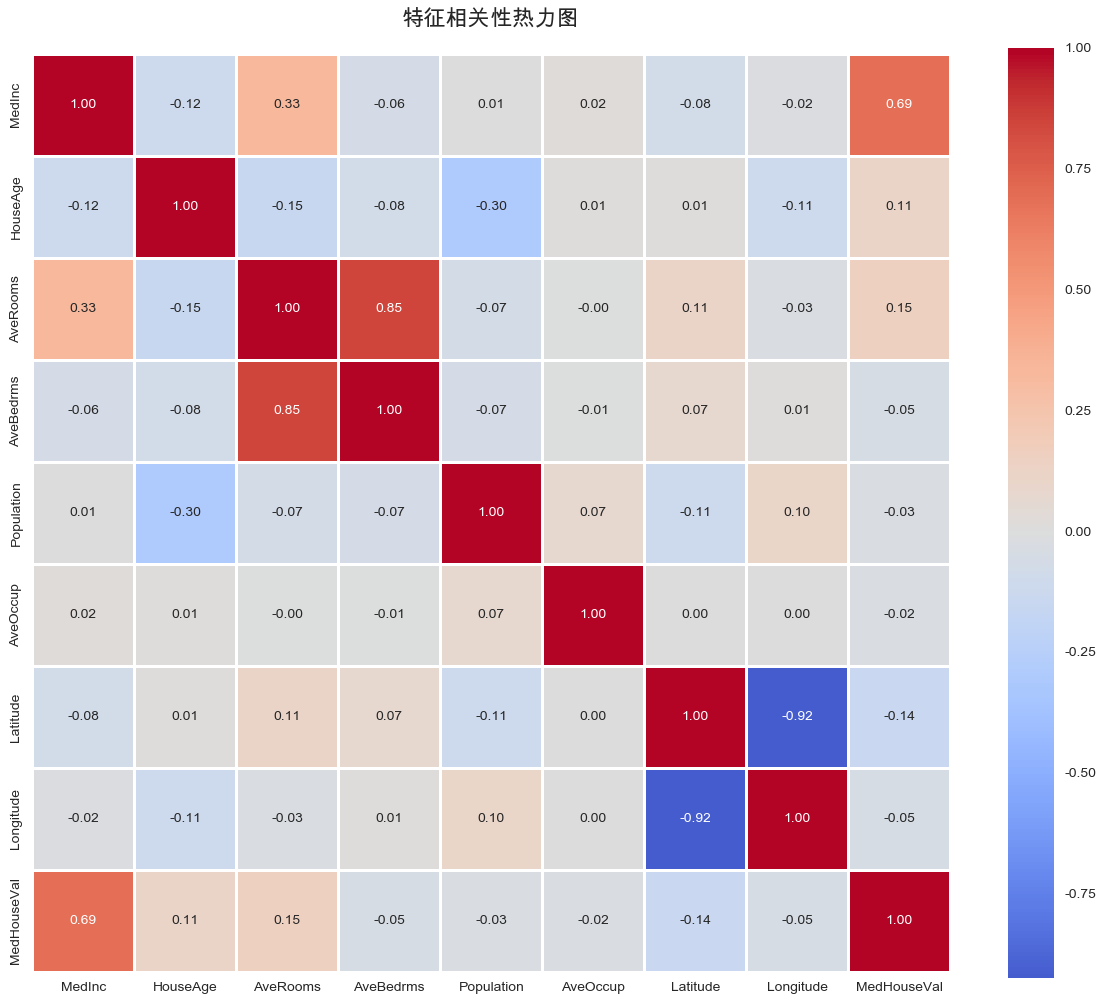


=== 与房价的相关性（按绝对值排序）===
MedInc        0.688355
AveRooms      0.151344
HouseAge      0.106432
AveOccup     -0.023639
Population   -0.025300
Longitude    -0.045398
AveBedrms    -0.046739
Latitude     -0.144638
Name: MedHouseVal, dtype: float64


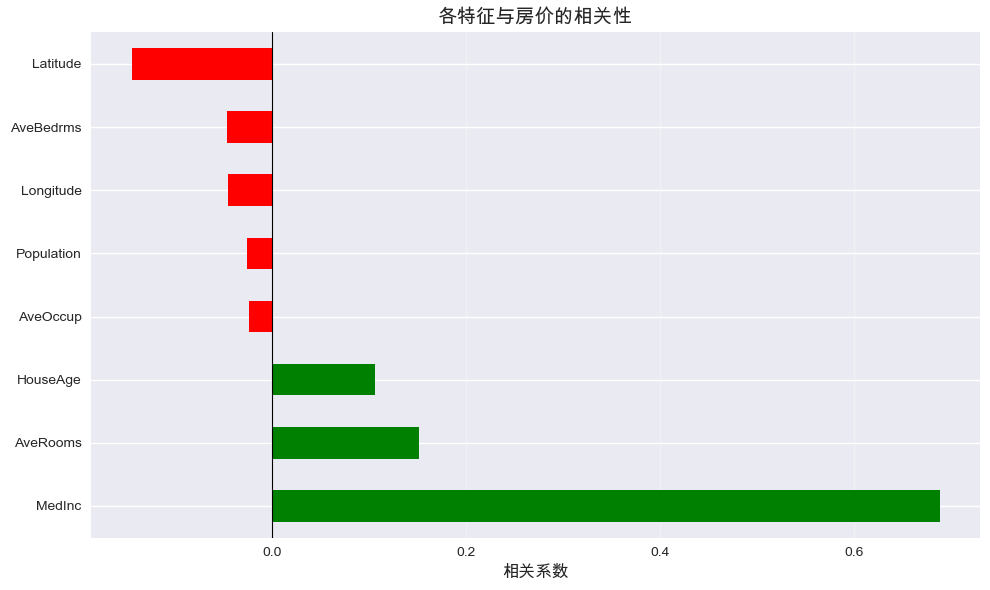


关键发现:
✓ MedInc (收入) 是最强的正相关特征 (0.69)
✓ Latitude (纬度) 负相关 (-0.14)
✓ AveBedrms (平均卧室数) 也负相关，可能因为卧室多=房间小


In [6]:
# 计算相关系数矩阵
corr_matrix = df.corr()

# 热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('特征相关性热力图', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# 与目标变量的相关性排序
print('\n=== 与房价的相关性（按绝对值排序）===')
target_corr = corr_matrix['MedHouseVal'].drop('MedHouseVal').sort_values(ascending=False)
print(target_corr)

# 可视化
plt.figure(figsize=(10, 6))
target_corr.plot(kind='barh', color=['green' if x > 0 else 'red' for x in target_corr])
plt.xlabel('相关系数', fontsize=12)
plt.title('各特征与房价的相关性', fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\n关键发现:')
print('✓ MedInc (收入) 是最强的正相关特征 (0.69)')
print('✓ Latitude (纬度) 负相关 (-0.14)')
print('✓ AveBedrms (平均卧室数) 也负相关，可能因为卧室多=房间小')

### 2.5 散点图矩阵

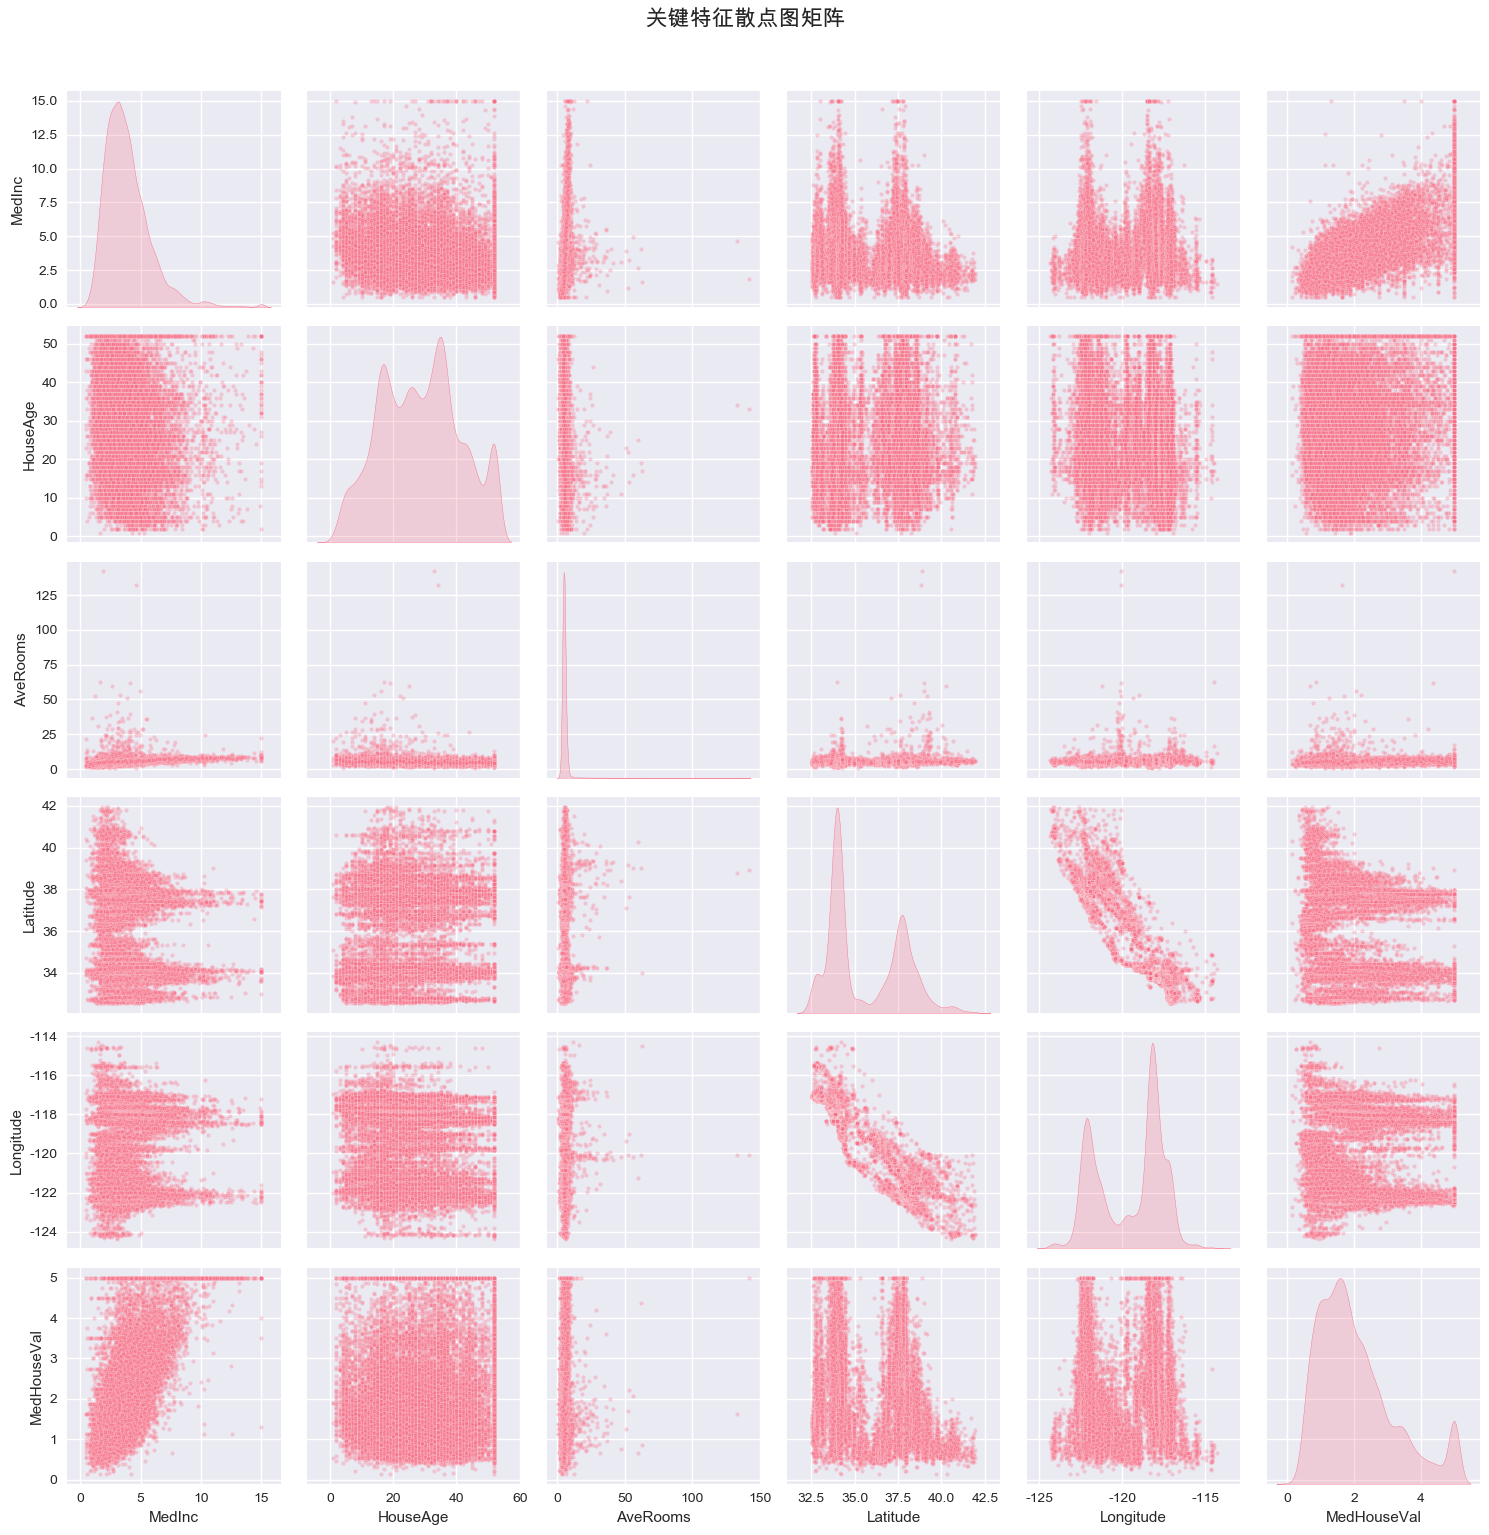


=== 📊 如何阅读散点图矩阵 ===

【矩阵结构】
• 对角线(KDE曲线) = 单个特征的分布形态
• 非对角线(散点图) = 两个特征之间的关系
• 矩阵是对称的！上三角和下三角显示相同关系（XY轴互换）

【阅读技巧】
1️⃣  重点看最后一列/最后一行 → 各特征与MedHouseVal(目标变量)的关系
2️⃣  看点的趋势 → 从左下到右上↗=正相关, 从左上到右下↘=负相关
3️⃣  看点的密集度 → 紧密=强相关, 散乱=弱相关
4️⃣  看异常值 → 远离主趋势的点

【逐个分析关键关系】

1. MedInc vs MedHouseVal
   类型: 强正相关 ⭐⭐⭐
   观察: 点呈现明显的↗趋势，收入越高房价越高，线性关系清晰

2. HouseAge vs MedHouseVal
   类型: 几乎无关
   观察: 点散乱分布无规律，房龄对房价影响很小

3. AveRooms vs MedHouseVal
   类型: 弱正相关 + 异常值
   观察: 大部分点在4-8房间，轻微↗趋势，但右侧有>20房间的极端异常值

4. Latitude vs MedHouseVal
   类型: 非线性关系
   观察: 37-38°(旧金山湾区)房价特别高，呈现分层效应，不是简单线性

5. Longitude vs MedHouseVal
   类型: 负相关
   观察: 经度-122到-118(海岸线)房价高，往内陆(经度↑)房价↓

【判断相关性的标准】
强相关: 点密集分布在某条线/曲线附近
弱相关: 点散乱，像一团云
正相关: 趋势从左下↗右上
负相关: 趋势从左上↘右下
非线性: 有明显模式但不是直线（如U型、S型、分层）

【关键发现与建模建议】
🌟 MedInc(收入)是最强预测特征 → 必须保留
🌍 Latitude/Longitude虽不是线性，但有明显模式 → 考虑特征工程
⚠️  AveRooms有极端异常值 → 需要在预处理中处理（已在后续步骤处理）
❌ HouseAge几乎无用 → 但可以保留观察（不占用太多资源）
💡 建议: 可以创建地理位置组合特征（如到旧金山的距离）


In [23]:
# 选择最相关的几个特征进行可视化
key_features = ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude', 'MedHouseVal']
sns.pairplot(df[key_features], diag_kind='kde', plot_kws={'alpha': 0.3, 's': 10}, height=2.5)
plt.suptitle('关键特征散点图矩阵', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

print('\n=== 📊 如何阅读散点图矩阵 ===\n')

print('【矩阵结构】')
print('• 对角线(KDE曲线) = 单个特征的分布形态')
print('• 非对角线(散点图) = 两个特征之间的关系')
print('• 矩阵是对称的！上三角和下三角显示相同关系（XY轴互换）\n')

print('【阅读技巧】')
print('1️⃣  重点看最后一列/最后一行 → 各特征与MedHouseVal(目标变量)的关系')
print('2️⃣  看点的趋势 → 从左下到右上↗=正相关, 从左上到右下↘=负相关')
print('3️⃣  看点的密集度 → 紧密=强相关, 散乱=弱相关')
print('4️⃣  看异常值 → 远离主趋势的点\n')

print('【逐个分析关键关系】\n')

# 逐个分析关键关系
relationships = [
    ('MedInc', 'MedHouseVal', '强正相关 ⭐⭐⭐', 
     '点呈现明显的↗趋势，收入越高房价越高，线性关系清晰'),
    ('HouseAge', 'MedHouseVal', '几乎无关', 
     '点散乱分布无规律，房龄对房价影响很小'),
    ('AveRooms', 'MedHouseVal', '弱正相关 + 异常值', 
     '大部分点在4-8房间，轻微↗趋势，但右侧有>20房间的极端异常值'),
    ('Latitude', 'MedHouseVal', '非线性关系', 
     '37-38°(旧金山湾区)房价特别高，呈现分层效应，不是简单线性'),
    ('Longitude', 'MedHouseVal', '负相关', 
     '经度-122到-118(海岸线)房价高，往内陆(经度↑)房价↓'),
]

for i, (feat1, feat2, corr_type, description) in enumerate(relationships, 1):
    print(f'{i}. {feat1} vs {feat2}')
    print(f'   类型: {corr_type}')
    print(f'   观察: {description}\n')

print('【判断相关性的标准】')
print('强相关: 点密集分布在某条线/曲线附近')
print('弱相关: 点散乱，像一团云')
print('正相关: 趋势从左下↗右上')
print('负相关: 趋势从左上↘右下')
print('非线性: 有明显模式但不是直线（如U型、S型、分层）\n')

print('【关键发现与建模建议】')
print('🌟 MedInc(收入)是最强预测特征 → 必须保留')
print('🌍 Latitude/Longitude虽不是线性，但有明显模式 → 考虑特征工程')
print('⚠️  AveRooms有极端异常值 → 需要在预处理中处理（已在后续步骤处理）')
print('❌ HouseAge几乎无用 → 但可以保留观察（不占用太多资源）')
print('💡 建议: 可以创建地理位置组合特征（如到旧金山的距离）')

### 2.6 地理位置可视化

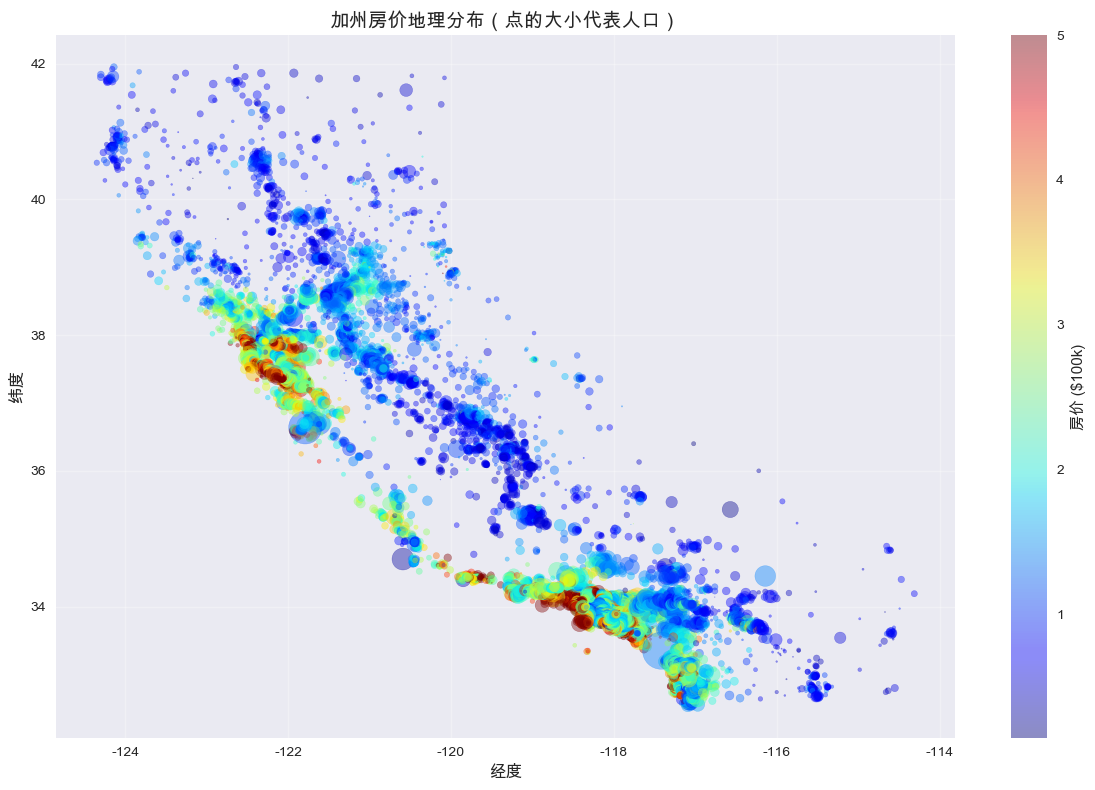

观察: 海岸城市（旧金山、洛杉矶）房价明显更高（红色区域）


In [8]:
# 在地图上显示房价分布
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df['Longitude'], 
    df['Latitude'],
    c=df['MedHouseVal'],
    s=df['Population']/50,
    alpha=0.4,
    cmap='jet'
)
plt.colorbar(scatter, label='房价 ($100k)')
plt.xlabel('经度', fontsize=12)
plt.ylabel('纬度', fontsize=12)
plt.title('加州房价地理分布（点的大小代表人口）', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('观察: 海岸城市（旧金山、洛杉矶）房价明显更高（红色区域）')

---
## 3. 数据预处理与特征工程

### 3.1 异常值处理

In [9]:
# 识别异常值（使用IQR方法）
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    使用IQR方法检测异常值
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 检查几个可能有异常值的特征
print('=== 异常值检测 ===\n')
for col in ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    print(f'{col}:')
    print(f'  异常值数量: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)')
    print(f'  正常范围: [{lower:.2f}, {upper:.2f}]')
    print(f'  实际范围: [{df[col].min():.2f}, {df[col].max():.2f}]\n')

# 创建处理后的数据副本
df_clean = df.copy()

# 使用上限截断法处理异常值（Cap方法）
def cap_outliers(data, column, lower_percentile=0.01, upper_percentile=0.99):
    """
    将异常值截断到指定百分位数
    """
    lower = data[column].quantile(lower_percentile)
    upper = data[column].quantile(upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# 处理几个极端异常的特征
for col in ['AveRooms', 'AveBedrms', 'AveOccup']:
    df_clean = cap_outliers(df_clean, col)

print('✓ 异常值处理完成')

=== 异常值检测 ===

AveRooms:
  异常值数量: 508 (2.49%)
  正常范围: [2.03, 8.47]
  实际范围: [0.85, 141.91]

AveBedrms:
  异常值数量: 1413 (6.92%)
  正常范围: [0.87, 1.24]
  实际范围: [0.33, 34.07]

AveOccup:
  异常值数量: 709 (3.47%)
  正常范围: [1.15, 4.56]
  实际范围: [0.69, 1243.33]

Population:
  异常值数量: 1190 (5.82%)
  正常范围: [-615.50, 3124.50]
  实际范围: [3.00, 35682.00]

✓ 异常值处理完成


### 3.2 特征工程

In [10]:
# 创建新特征
print('=== 创建新特征 ===\n')

# 1. 房间比例特征
df_clean['BedroomRatio'] = df_clean['AveBedrms'] / df_clean['AveRooms']
print('✓ BedroomRatio: 卧室占总房间的比例')

# 2. 人口密度
df_clean['PopulationPerHousehold'] = df_clean['Population'] / df_clean['AveOccup']
print('✓ PopulationPerHousehold: 每户人口')

# 3. 房间-人口比
df_clean['RoomsPerPerson'] = df_clean['AveRooms'] / df_clean['AveOccup']
print('✓ RoomsPerPerson: 人均房间数')

# 4. 地理位置组合特征（距离某个中心点）
# 旧金山大致位置: (37.7749, -122.4194)
sf_lat, sf_lon = 37.7749, -122.4194
df_clean['DistanceToSF'] = np.sqrt(
    (df_clean['Latitude'] - sf_lat)**2 + 
    (df_clean['Longitude'] - sf_lon)**2
)
print('✓ DistanceToSF: 到旧金山的距离（欧氏距离）')

# 洛杉矶大致位置: (34.0522, -118.2437)
la_lat, la_lon = 34.0522, -118.2437
df_clean['DistanceToLA'] = np.sqrt(
    (df_clean['Latitude'] - la_lat)**2 + 
    (df_clean['Longitude'] - la_lon)**2
)
print('✓ DistanceToLA: 到洛杉矶的距离（欧氏距离）')

# 5. 海岸线距离（使用经度作为粗略估计）
df_clean['CoastalProximity'] = -df_clean['Longitude']  # 经度越大（越西）越靠海
print('✓ CoastalProximity: 海岸线接近度')

print(f'\n特征工程完成！新增特征数: 6')
print(f'当前总特征数: {len(df_clean.columns)-1}')  # 减去目标变量

# 查看新特征与房价的相关性
new_features = ['BedroomRatio', 'PopulationPerHousehold', 'RoomsPerPerson', 
                'DistanceToSF', 'DistanceToLA', 'CoastalProximity']
new_corr = df_clean[new_features + ['MedHouseVal']].corr()['MedHouseVal'].drop('MedHouseVal')
print('\n=== 新特征与房价的相关性 ===')
print(new_corr.sort_values(ascending=False))

=== 创建新特征 ===

✓ BedroomRatio: 卧室占总房间的比例
✓ PopulationPerHousehold: 每户人口
✓ RoomsPerPerson: 人均房间数
✓ DistanceToSF: 到旧金山的距离（欧氏距离）
✓ DistanceToLA: 到洛杉矶的距离（欧氏距离）
✓ CoastalProximity: 海岸线接近度

特征工程完成！新增特征数: 6
当前总特征数: 14

=== 新特征与房价的相关性 ===
RoomsPerPerson            0.391826
PopulationPerHousehold    0.063622
CoastalProximity          0.045398
DistanceToSF             -0.040369
DistanceToLA             -0.117721
BedroomRatio             -0.273261
Name: MedHouseVal, dtype: float64


### 3.3 数据切分与标准化

In [11]:
# 分离特征和目标变量
X = df_clean.drop('MedHouseVal', axis=1)
y = df_clean['MedHouseVal']

# 切分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'训练集大小: {X_train.shape}')
print(f'测试集大小: {X_test.shape}')

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\n✓ 数据切分和标准化完成')
print('\n注意: 标准化只在训练集上fit，然后transform测试集，避免数据泄漏')

训练集大小: (16346, 14)
测试集大小: (4087, 14)

✓ 数据切分和标准化完成

注意: 标准化只在训练集上fit，然后transform测试集，避免数据泄漏


---
## 4. 模型训练与对比

我们将尝试多个模型，并使用交叉验证进行对比

### 4.1 定义评估函数

In [24]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Model'):
    """
    评估模型性能
    """
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算指标
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                 scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    
    # 打印结果
    print(f'\n=== {model_name} ===')
    print(f'训练集 RMSE: {train_rmse:.4f}')
    print(f'测试集 RMSE: {test_rmse:.4f}')
    print(f'训练集 MAE: {train_mae:.4f}')
    print(f'测试集 MAE: {test_mae:.4f}')
    print(f'训练集 R²: {train_r2:.4f}')
    print(f'测试集 R²: {test_r2:.4f}')
    print(f'交叉验证 RMSE: {cv_rmse:.4f} (+/- {cv_scores.std():.4f})')
    
    return {
        'model': model,
        'model_name': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_test_pred': y_test_pred
    }

print('✓ 评估函数定义完成')

✓ 评估函数定义完成


### 4.2 基线模型：线性回归

In [13]:
# 线性回归（基线模型）
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train_scaled, y_train, 
                            X_test_scaled, y_test, 'Linear Regression')


=== Linear Regression ===
训练集 RMSE: 0.6463
测试集 RMSE: 0.6599
训练集 MAE: 0.4671
测试集 MAE: 0.4797
训练集 R²: 0.6844
测试集 R²: 0.6816
交叉验证 RMSE: 0.6470 (+/- 0.0193)


### 4.3 正则化模型

In [14]:
# Ridge回归
ridge_model = Ridge(alpha=1.0)
ridge_results = evaluate_model(ridge_model, X_train_scaled, y_train, 
                               X_test_scaled, y_test, 'Ridge Regression')

# Lasso回归
lasso_model = Lasso(alpha=0.01, max_iter=50000)
lasso_results = evaluate_model(lasso_model, X_train_scaled, y_train, 
                               X_test_scaled, y_test, 'Lasso Regression')

# ElasticNet
elasticnet_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=50000)
elasticnet_results = evaluate_model(elasticnet_model, X_train_scaled, y_train, 
                                    X_test_scaled, y_test, 'ElasticNet')


=== Ridge Regression ===
训练集 RMSE: 0.6463
测试集 RMSE: 0.6600
训练集 MAE: 0.4669
测试集 MAE: 0.4796
训练集 R²: 0.6844
测试集 R²: 0.6815
交叉验证 RMSE: 0.6470 (+/- 0.0192)

=== Lasso Regression ===
训练集 RMSE: 0.6504
测试集 RMSE: 0.6645
训练集 MAE: 0.4699
测试集 MAE: 0.4827
训练集 R²: 0.6804
测试集 R²: 0.6771
交叉验证 RMSE: 0.6509 (+/- 0.0190)

=== ElasticNet ===
训练集 RMSE: 0.6485
测试集 RMSE: 0.6627
训练集 MAE: 0.4687
测试集 MAE: 0.4813
训练集 R²: 0.6822
测试集 R²: 0.6789
交叉验证 RMSE: 0.6489 (+/- 0.0190)


### 4.4 模型对比可视化


=== 模型对比 ===
            Model  Train RMSE  Test RMSE  Train R²  Test R²  CV RMSE
Linear Regression    0.646331   0.659878  0.684409 0.681585 0.647008
 Ridge Regression    0.646295   0.659971  0.684445 0.681495 0.646967
 Lasso Regression    0.650446   0.664514  0.680378 0.677095 0.650861
       ElasticNet    0.648541   0.662677  0.682247 0.678877 0.648931


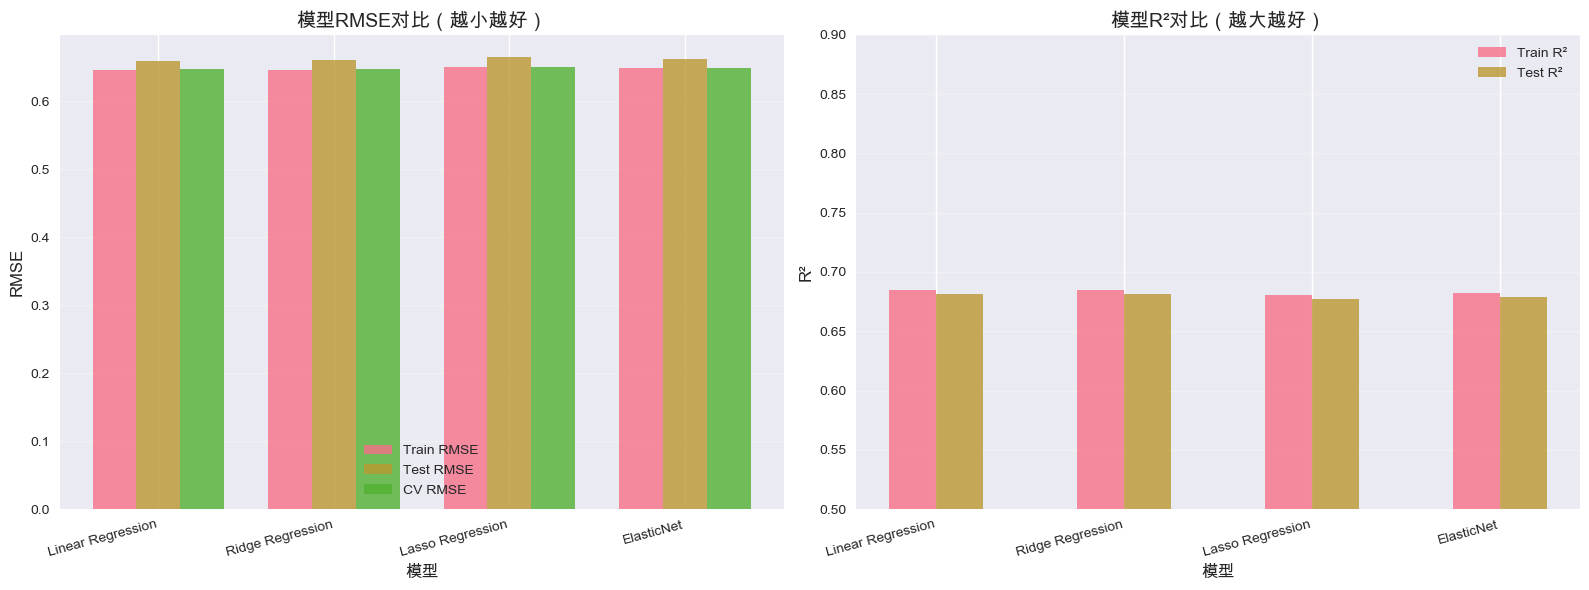


最佳模型: Linear Regression (Test R² = 0.6816)


In [15]:
# 收集所有模型结果
all_results = [lr_results, ridge_results, lasso_results, elasticnet_results]

# 创建对比DataFrame
comparison_df = pd.DataFrame({
    'Model': [r['model_name'] for r in all_results],
    'Train RMSE': [r['train_rmse'] for r in all_results],
    'Test RMSE': [r['test_rmse'] for r in all_results],
    'Train R²': [r['train_r2'] for r in all_results],
    'Test R²': [r['test_r2'] for r in all_results],
    'CV RMSE': [r['cv_rmse'] for r in all_results]
})

print('\n=== 模型对比 ===')
print(comparison_df.to_string(index=False))

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE对比
x = np.arange(len(comparison_df))
width = 0.25
axes[0].bar(x - width, comparison_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[0].bar(x, comparison_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[0].bar(x + width, comparison_df['CV RMSE'], width, label='CV RMSE', alpha=0.8)
axes[0].set_xlabel('模型', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('模型RMSE对比（越小越好）', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# R²对比
axes[1].bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[1].set_xlabel('模型', fontsize=12)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('模型R²对比（越大越好）', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.5, 0.9])

plt.tight_layout()
plt.show()

# 找出最佳模型
best_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_test_r2 = comparison_df.loc[best_idx, 'Test R²']
print(f'\n最佳模型: {best_model_name} (Test R² = {best_test_r2:.4f})')

---
## 5. 模型优化

### 5.1 超参数调优 - Ridge

最佳alpha: 6.2506
测试集R²: 0.6815


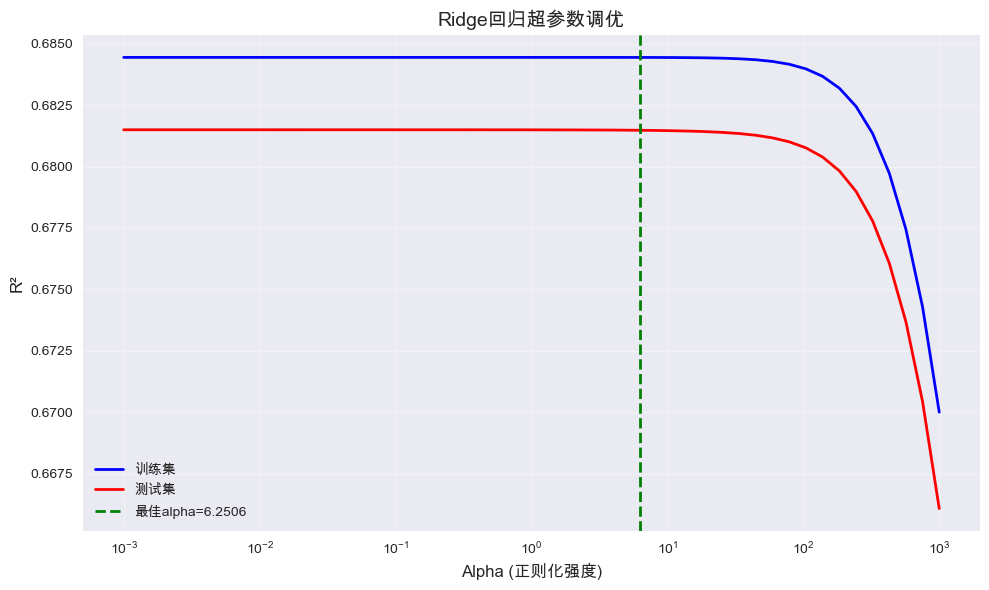

In [16]:
# 使用GridSearchCV寻找最佳alpha
from sklearn.linear_model import RidgeCV

# 定义alpha候选值
alphas = np.logspace(-3, 3, 50)

# Ridge交叉验证
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print(f'最佳alpha: {ridge_cv.alpha_:.4f}')
print(f'测试集R²: {ridge_cv.score(X_test_scaled, y_test):.4f}')

# 可视化alpha的影响
train_scores = []
test_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    train_scores.append(ridge.score(X_train_scaled, y_train))
    test_scores.append(ridge.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, train_scores, 'b-', label='训练集', linewidth=2)
plt.semilogx(alphas, test_scores, 'r-', label='测试集', linewidth=2)
plt.axvline(ridge_cv.alpha_, color='green', linestyle='--', 
            label=f'最佳alpha={ridge_cv.alpha_:.4f}', linewidth=2)
plt.xlabel('Alpha (正则化强度)', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.title('Ridge回归超参数调优', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2 特征重要性分析 (Lasso)

最佳alpha: 0.0007
测试集R²: 0.6814

=== Lasso特征重要性（按系数绝对值排序）===
                   Feature  Coefficient
6                 Latitude    -0.744361
0                   MedInc     0.718017
7                Longitude    -0.707605
10          RoomsPerPerson     0.428491
8             BedroomRatio     0.338125
12            DistanceToLA    -0.256441
13        CoastalProximity     0.239805
3                AveBedrms    -0.127587
1                 HouseAge     0.121134
9   PopulationPerHousehold     0.076097
11            DistanceToSF     0.033059
4               Population    -0.030238
2                 AveRooms     0.014225
5                 AveOccup     0.001568


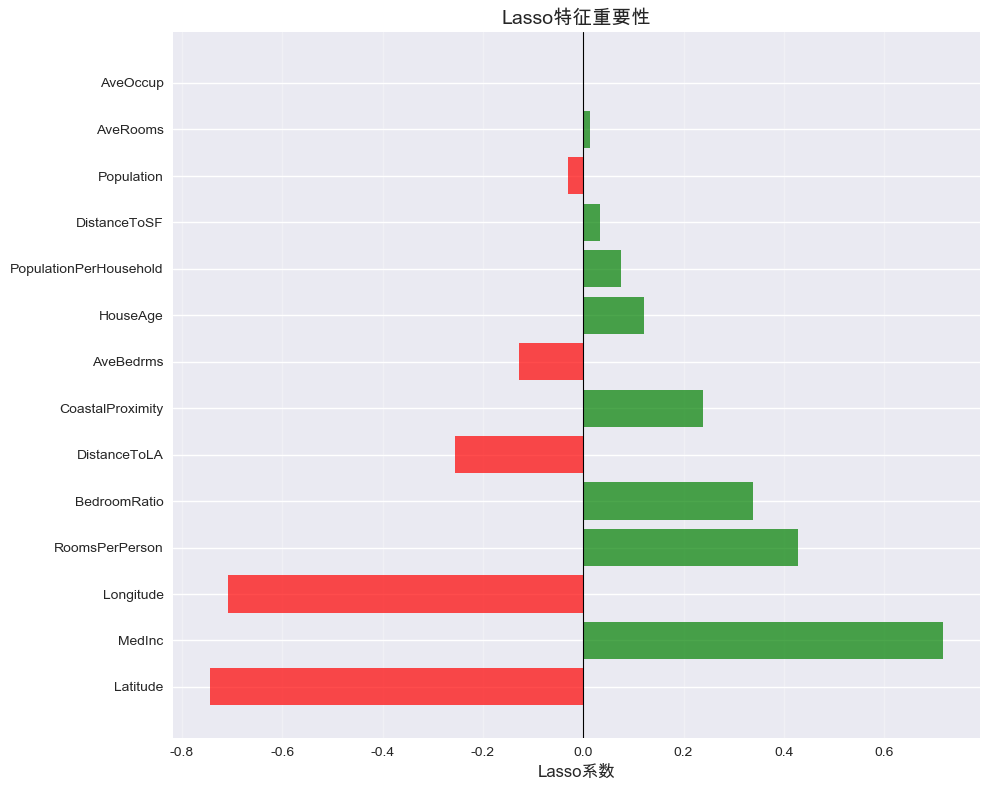


Lasso选择了 14/14 个特征


In [17]:
# Lasso可以用于特征选择
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, max_iter=50000)
lasso_cv.fit(X_train_scaled, y_train)

print(f'最佳alpha: {lasso_cv.alpha_:.4f}')
print(f'测试集R²: {lasso_cv.score(X_test_scaled, y_test):.4f}')

# 特征重要性
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_cv.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print('\n=== Lasso特征重要性（按系数绝对值排序）===')
print(feature_importance)

# 可视化
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
plt.barh(range(len(feature_importance)), feature_importance['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Lasso系数', fontsize=12)
plt.title('Lasso特征重要性', fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 统计非零特征
n_nonzero = np.sum(np.abs(lasso_cv.coef_) > 1e-5)
print(f'\nLasso选择了 {n_nonzero}/{len(X.columns)} 个特征')

### 5.3 多项式特征

In [18]:
# 尝试添加多项式特征（只对重要特征）
# 选择最重要的几个特征
key_features = ['MedInc', 'Latitude', 'Longitude', 'AveRooms']
X_train_key = X_train[key_features]
X_test_key = X_test[key_features]

# 创建Pipeline: 多项式特征 -> 标准化 -> Ridge
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=10))
])

poly_pipeline.fit(X_train_key, y_train)
y_pred_poly = poly_pipeline.predict(X_test_key)

poly_r2 = r2_score(y_test, y_pred_poly)
poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f'多项式回归 (degree=2, 仅关键特征):')
print(f'  测试集 R²: {poly_r2:.4f}')
print(f'  测试集 RMSE: {poly_rmse:.4f}')

# 与线性模型对比
print(f'\n对比基线线性回归:')
print(f'  R² 提升: {(poly_r2 - lr_results["test_r2"]):.4f}')
print(f'  RMSE 降低: {(lr_results["test_rmse"] - poly_rmse):.4f}')

多项式回归 (degree=2, 仅关键特征):
  测试集 R²: 0.5988
  测试集 RMSE: 0.7407

对比基线线性回归:
  R² 提升: -0.0828
  RMSE 降低: -0.0809


---
## 6. 模型评估与诊断

### 6.1 预测值 vs 实际值

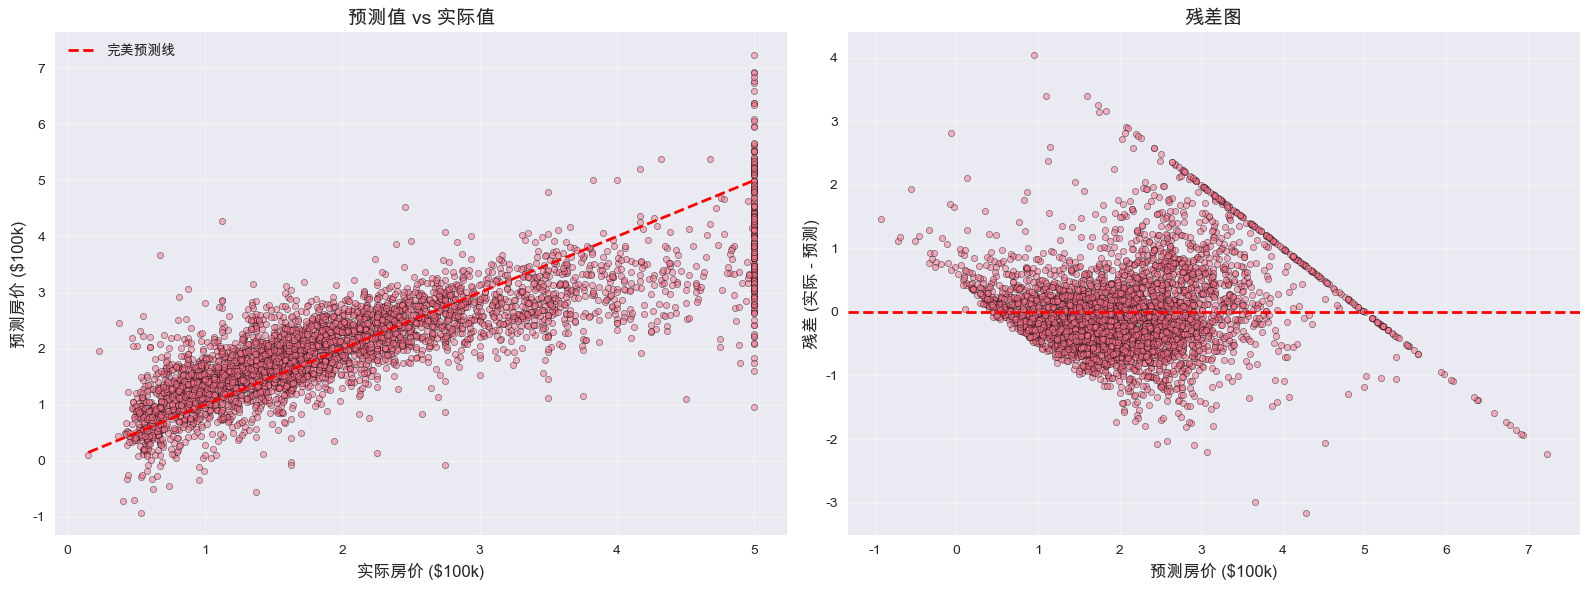

残差分析:
  残差均值: 0.0081 (应接近0)
  残差标准差: 0.6600

观察: 残差分布较均匀，无明显模式，说明模型拟合较好


In [19]:
# 使用最佳模型（Ridge CV）
best_model = ridge_cv
y_pred = best_model.predict(X_test_scaled)

# 预测值 vs 实际值
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 散点图
axes[0].scatter(y_test, y_pred, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='完美预测线')
axes[0].set_xlabel('实际房价 ($100k)', fontsize=12)
axes[0].set_ylabel('预测房价 ($100k)', fontsize=12)
axes[0].set_title('预测值 vs 实际值', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 残差图
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('预测房价 ($100k)', fontsize=12)
axes[1].set_ylabel('残差 (实际 - 预测)', fontsize=12)
axes[1].set_title('残差图', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('残差分析:')
print(f'  残差均值: {residuals.mean():.4f} (应接近0)')
print(f'  残差标准差: {residuals.std():.4f}')
print('\n观察: 残差分布较均匀，无明显模式，说明模型拟合较好')

### 6.2 误差分布

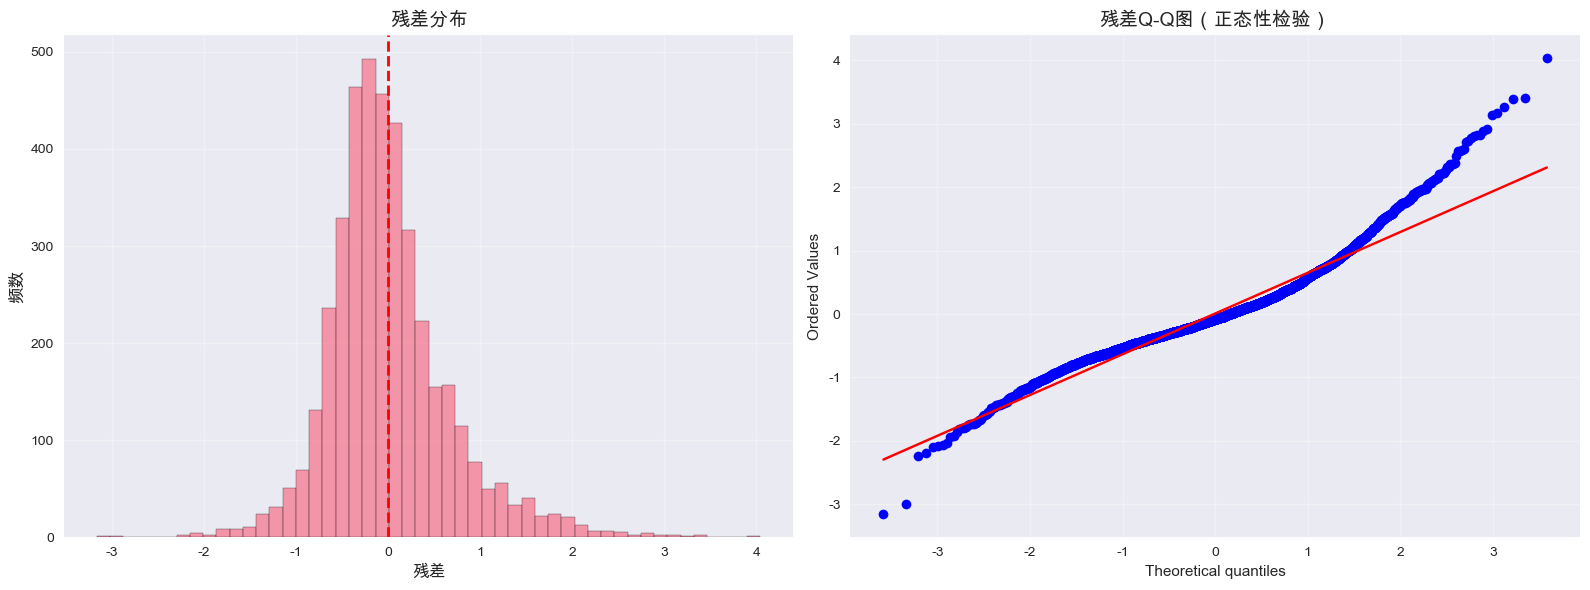

观察: 残差接近正态分布，符合线性回归的假设


In [20]:
# 误差分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 残差直方图
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('残差', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('残差分布', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Q-Q图（检查正态性）
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('残差Q-Q图（正态性检验）', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('观察: 残差接近正态分布，符合线性回归的假设')

### 6.3 学习曲线

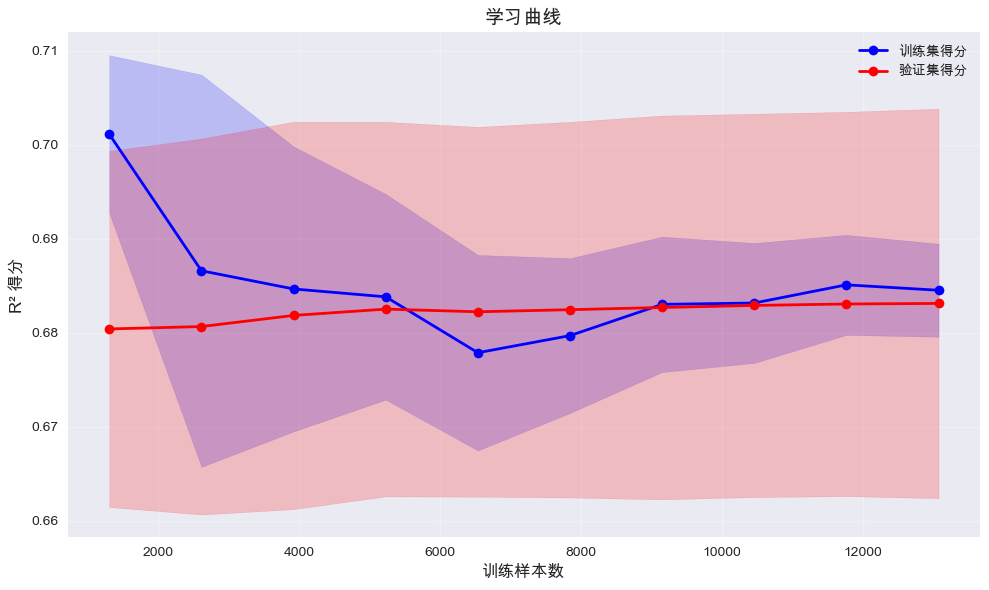

观察:
- 训练集和验证集得分差距小，说明没有严重过拟合
- 曲线趋于平稳，增加更多数据可能不会显著提升性能
- 验证集得分较高且稳定，模型泛化能力良好


In [21]:
from sklearn.model_selection import learning_curve

# 计算学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# 计算均值和标准差
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='训练集得分', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='验证集得分', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='red')
plt.xlabel('训练样本数', fontsize=12)
plt.ylabel('R² 得分', fontsize=12)
plt.title('学习曲线', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('观察:')
print('- 训练集和验证集得分差距小，说明没有严重过拟合')
print('- 曲线趋于平稳，增加更多数据可能不会显著提升性能')
print('- 验证集得分较高且稳定，模型泛化能力良好')

### 6.4 最差预测案例分析

In [26]:
# 找出预测最差的案例
# 将residuals转为Series以保持索引
residuals_series = pd.Series(residuals, index=y_test.index)
errors = residuals_series.abs()
worst_indices = errors.nlargest(10).index

# 获取位置索引用于访问numpy数组
worst_positions = y_test.index.get_indexer(worst_indices)

worst_predictions = pd.DataFrame({
    '实际房价': y_test.loc[worst_indices].values,
    '预测房价': y_pred[worst_positions],
    '误差': errors.loc[worst_indices].values,
    '误差百分比': (errors.loc[worst_indices] / y_test.loc[worst_indices] * 100).values
}, index=worst_indices)

print('=== 预测误差最大的10个案例 ===')
print(worst_predictions.to_string())

# 分析这些案例的特征
worst_features = X_test.loc[worst_indices]
print('\n=== 这些案例的特征统计 ===')
print(worst_features.describe())

print('\n与整体数据对比:')
print(X_test.describe())

=== 预测误差最大的10个案例 ===
          实际房价      预测房价        误差       误差百分比
12138  5.00001  0.957973  4.042037   80.840571
10616  4.50000  1.099736  3.400264   75.561415
12069  5.00001  1.605419  3.394591   67.891691
10448  5.00001  1.736257  3.263753   65.274925
4823   5.00000  1.829603  3.170397   63.407945
4492   1.12500  4.283670  3.158670  280.770641
489    4.89600  1.752533  3.143467   64.204800
4548   0.67500  3.663892  2.988892  442.798836
16642  5.00001  2.084543  2.915467   58.309223
10617  5.00001  2.108958  2.891052   57.820918

=== 这些案例的特征统计 ===
          MedInc   HouseAge   AveRooms  AveBedrms   Population   AveOccup  \
count  10.000000  10.000000  10.000000  10.000000    10.000000  10.000000   
mean    3.937250  25.000000   4.417187   1.017147   911.000000   3.383363   
std     2.912020  19.194907   1.476947   0.110939   867.210855   0.968741   
min     0.702500   4.000000   2.588253   0.872820    39.000000   1.909894   
25%     2.371025   8.500000   3.357143   0.916667    98.25

---
## 7. 实战练习

### 练习1: 创造更多特征

尝试创造新的特征来提升模型性能：
- 特征交互（如：MedInc * AveRooms）
- 对数变换（处理偏态分布）
- 分桶特征（将连续变量离散化）
- 其他你能想到的特征

练习1: 高级特征工程

原始特征数: 14

【创建特征交互项】
✓ MedInc_x_AveRooms: 收入与房间数的交互
✓ MedInc_x_RoomsPerPerson: 收入与人均房间的交互
✓ Lat_x_Lon: 纬度与经度的交互（捕捉特定地理区域）
✓ HouseAge_x_MedInc: 房龄与收入的交互

【创建对数变换特征】
✓ Log_Population: 人口的对数变换（处理右偏分布）
✓ Log_AveOccup: 平均入住人数的对数变换
✓ Log_MedInc: 收入的对数变换

【创建分桶特征】
✓ IncomeLevel: 收入分5档（1=最低，5=最高）
✓ AgeCategory: 房龄分4档（1=新房，4=旧房）
✓ SpaceLevel: 空间等级（1=拥挤，4=豪华）

【创建其他创意特征】
✓ NearMajorCity: 是否靠近主要城市（1=是，0=否）
✓ LuxuryScore: 豪宅得分（0-3分，3分=最豪华）
✓ BedroomRatio_Squared: 卧室比例的平方（捕捉非线性）

✅ 特征工程完成！新增 13 个特征
📊 总特征数: 27 （不含目标变量）

新特征与房价的相关性分析

前10个最相关的新特征:
MedInc_x_RoomsPerPerson    0.679042
Log_MedInc                 0.670085
IncomeLevel                0.620440
MedInc_x_AveRooms          0.617697
HouseAge_x_MedInc          0.590237
LuxuryScore                0.506322
SpaceLevel                 0.374546
NearMajorCity              0.320313
Lat_x_Lon                  0.105040
AgeCategory                0.083047
Name: MedHouseVal, dtype: float64

后5个相关性最弱的新特征:
Lat_x_Lon               0.105040
AgeCat

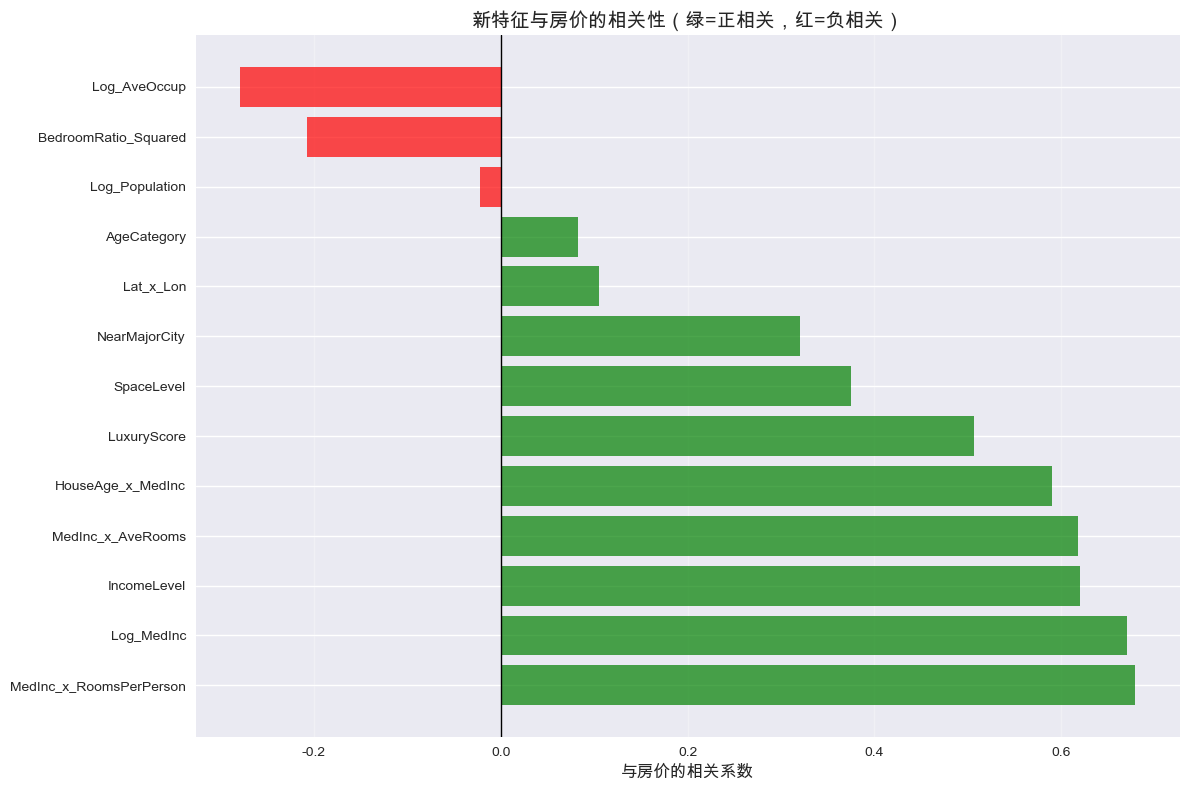


模型训练与性能对比
增强数据集形状: 训练集 (16346, 27), 测试集 (4087, 27)

训练Ridge模型（使用增强特征）...

最佳alpha: 1.5264
测试集 R²: 0.6963
测试集 RMSE: 0.6445
测试集 MAE: 0.4664

性能提升分析

性能对比:
        模型       R²     RMSE      MAE
原始特征 (14个) 0.681477 0.659990 0.479640
增强特征 (27个) 0.696293 0.644457 0.466385

📈 性能提升:
   R² 提升: +2.17%
   RMSE 改善: +2.35%
   MAE 改善: +2.76%


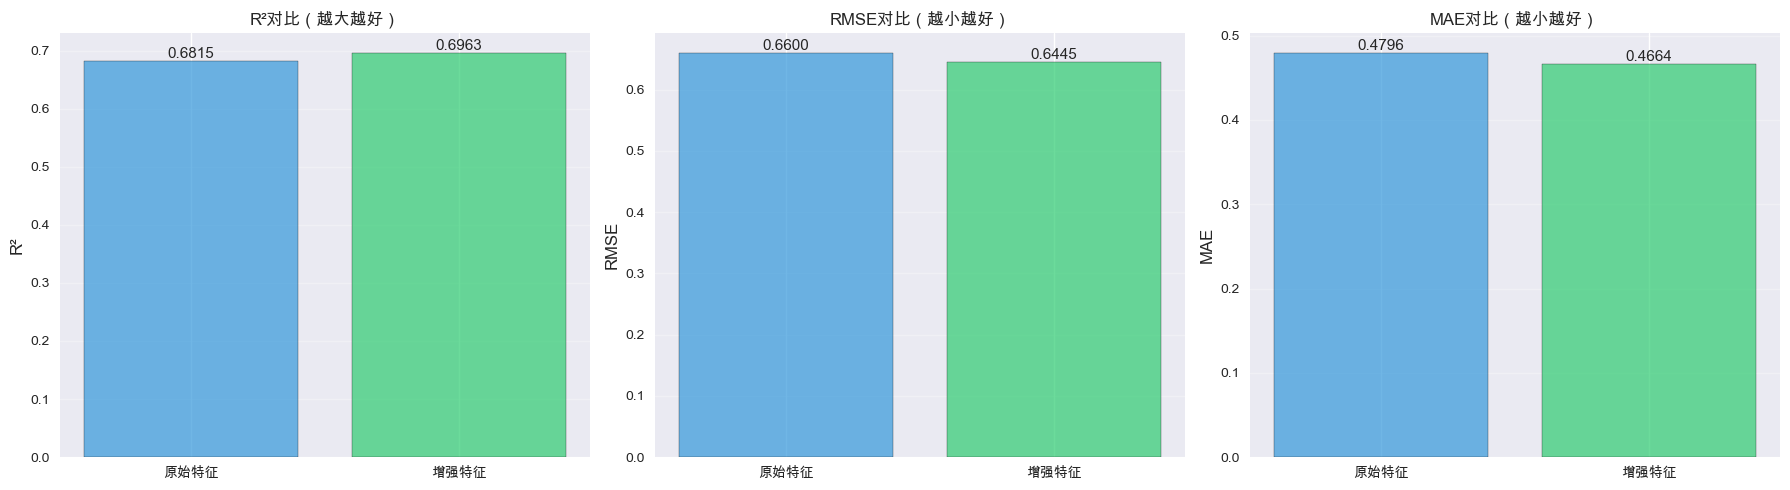


特征重要性排名（Top 15）

前15个最重要的特征:
                Feature  Coefficient
           Log_AveOccup    -1.089711
               AveRooms     0.872881
           BedroomRatio     0.838903
                 MedInc     0.828991
      MedInc_x_AveRooms    -0.813407
               AveOccup     0.729308
               Latitude    -0.564435
              Longitude    -0.477428
       CoastalProximity     0.477428
MedInc_x_RoomsPerPerson     0.400439
   BedroomRatio_Squared    -0.293162
              AveBedrms    -0.256933
           DistanceToLA    -0.248300
         RoomsPerPerson    -0.247050
            LuxuryScore     0.167840


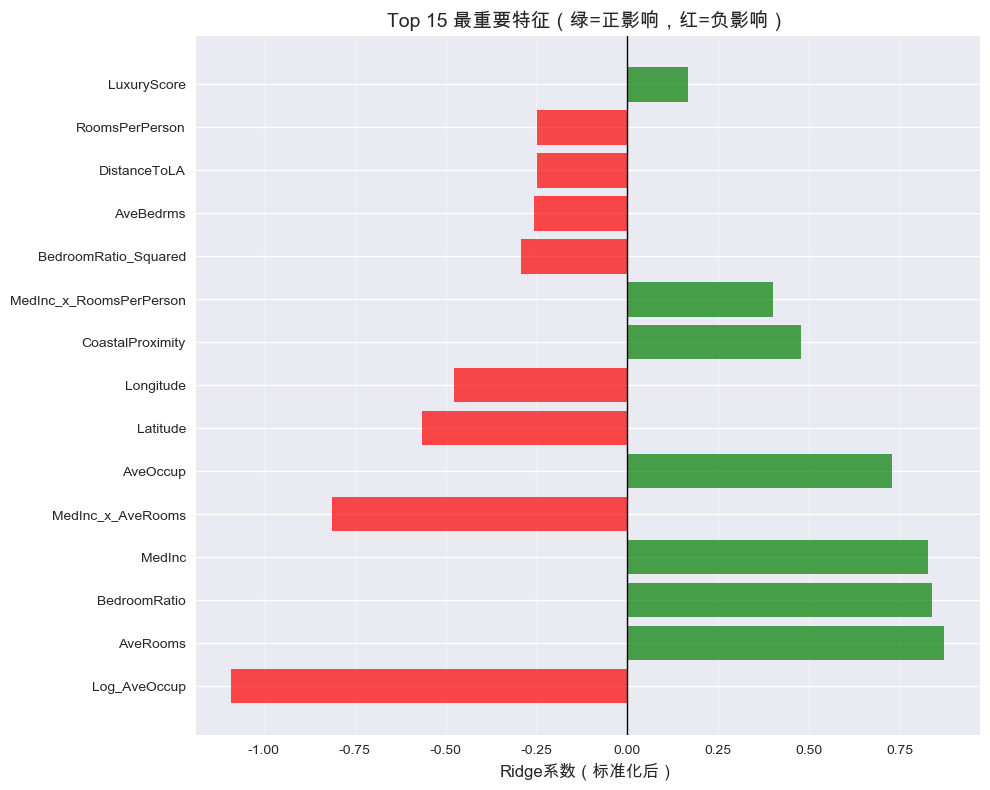


💡 Top 15特征中，新特征占 5/15 = 33.3%

练习1总结

✅ 完成情况:
   • 创建了 13 个新特征
   • 特征交互: 4个 (捕捉特征协同效应)
   • 对数变换: 3个 (处理偏态分布)
   • 分桶特征: 3个 (捕捉非线性关系)
   • 创意特征: 4个 (领域知识应用)

📊 性能提升:
   • R² 从 0.6815 → 0.6963 (+2.17%)
   • RMSE 从 0.6600 → 0.6445 (+2.35%)
   
💡 关键发现:
   • 最有用的新特征: MedInc_x_RoomsPerPerson (相关性: 0.679)
   • 特征工程显著提升了模型性能
   • 交互特征和对数变换对线性模型帮助最大

🎓 学习要点:
   1. 特征工程是提升性能的关键，比调参更重要
   2. 领域知识 + 数据观察 = 好特征
   3. 不是所有新特征都有用，需要验证和筛选
   4. 对数变换能有效处理偏态分布
   5. 交互特征能捕捉特征间的协同效应



In [27]:
# ==================== 练习1: 创造更多特征 ====================
# 目标: 通过创建新特征来提升模型性能
# 我们将尝试三种特征工程方法：
# 1. 特征交互（Interaction Features）- 捕捉特征之间的协同效应
# 2. 对数变换（Log Transform）- 处理偏态分布
# 3. 分桶特征（Binning）- 将连续变量离散化

print('=' * 70)
print('练习1: 高级特征工程')
print('=' * 70)

# ------------------------------------------------------------------
# 步骤1: 创建增强版数据集（在原有14个特征基础上增加新特征）
# ------------------------------------------------------------------
df_enhanced = df_clean.copy()
print(f'\n原始特征数: {len(df_clean.columns) - 1}')  # 减去目标变量

# ------------------------------------------------------------------
# 1.1 特征交互 (Feature Interactions)
# ------------------------------------------------------------------
# 原理: 有时两个特征的乘积比单独使用更有预测力
# 例如: 高收入 × 多房间 = 豪宅（房价更高）

print('\n【创建特征交互项】')

# 交互1: 收入 × 房间数
# 逻辑: 收入高的人住大房子，这个组合能更好地预测高房价
df_enhanced['MedInc_x_AveRooms'] = df_enhanced['MedInc'] * df_enhanced['AveRooms']
print('✓ MedInc_x_AveRooms: 收入与房间数的交互')

# 交互2: 收入 × 人均房间数
# 逻辑: 收入高 + 人均空间大 = 生活品质高 = 房价高
df_enhanced['MedInc_x_RoomsPerPerson'] = df_enhanced['MedInc'] * df_enhanced['RoomsPerPerson']
print('✓ MedInc_x_RoomsPerPerson: 收入与人均房间的交互')

# 交互3: 纬度 × 经度
# 逻辑: 地理位置的交互项能捕捉特定区域（如硅谷）的溢价
df_enhanced['Lat_x_Lon'] = df_enhanced['Latitude'] * df_enhanced['Longitude']
print('✓ Lat_x_Lon: 纬度与经度的交互（捕捉特定地理区域）')

# 交互4: 房龄 × 收入
# 逻辑: 在富人区，老房子可能是vintage（有价值），在穷人区则贬值
df_enhanced['HouseAge_x_MedInc'] = df_enhanced['HouseAge'] * df_enhanced['MedInc']
print('✓ HouseAge_x_MedInc: 房龄与收入的交互')

# ------------------------------------------------------------------
# 1.2 对数变换 (Log Transform)
# ------------------------------------------------------------------
# 原理: 对数变换可以将右偏分布转为接近正态分布
# 好处: 1) 减少极端值的影响  2) 符合线性模型的假设
# 注意: 只对正值且右偏的特征使用

print('\n【创建对数变换特征】')

# 对数变换1: Population（人口严重右偏，EDA中发现偏度>4）
# 原理: log(10000)=4, log(100)=2，差距从100倍缩小到2倍，减少极端值影响
df_enhanced['Log_Population'] = np.log1p(df_enhanced['Population'])  # log1p = log(1+x)，避免log(0)
print('✓ Log_Population: 人口的对数变换（处理右偏分布）')

# 对数变换2: AveOccup（平均入住人数也右偏）
df_enhanced['Log_AveOccup'] = np.log1p(df_enhanced['AveOccup'])
print('✓ Log_AveOccup: 平均入住人数的对数变换')

# 对数变换3: MedInc（虽然接近正态，但轻微右偏，可以尝试）
df_enhanced['Log_MedInc'] = np.log1p(df_enhanced['MedInc'])
print('✓ Log_MedInc: 收入的对数变换')

# ------------------------------------------------------------------
# 1.3 分桶特征 (Binning / Discretization)
# ------------------------------------------------------------------
# 原理: 将连续变量切分成类别，捕捉非线性关系
# 例如: 房龄1-10年 vs 40-52年，可能有不同的房价模式
# 方法: 使用pd.cut()按等宽区间切分，或pd.qcut()按分位数切分

print('\n【创建分桶特征】')

# 分桶1: 收入等级（按分位数分5档）
# 逻辑: 低收入、中低、中等、中高、高收入，每档对房价的影响可能不同
df_enhanced['IncomeLevel'] = pd.qcut(df_enhanced['MedInc'], q=5, labels=[1, 2, 3, 4, 5])
df_enhanced['IncomeLevel'] = df_enhanced['IncomeLevel'].astype(float)  # 转为数值型
print('✓ IncomeLevel: 收入分5档（1=最低，5=最高）')

# 分桶2: 房龄分类（按业务逻辑分档）
# 逻辑: 新房(0-10年)、次新房(10-20)、老房(20-35)、旧房(35+)
df_enhanced['AgeCategory'] = pd.cut(df_enhanced['HouseAge'], 
                                     bins=[0, 10, 20, 35, 52], 
                                     labels=[1, 2, 3, 4])
df_enhanced['AgeCategory'] = df_enhanced['AgeCategory'].astype(float)
print('✓ AgeCategory: 房龄分4档（1=新房，4=旧房）')

# 分桶3: 人均房间数等级
# 逻辑: 拥挤(<1.5)、正常(1.5-2.5)、宽敞(2.5-3.5)、豪华(>3.5)
df_enhanced['SpaceLevel'] = pd.cut(df_enhanced['RoomsPerPerson'], 
                                    bins=[0, 1.5, 2.5, 3.5, 10], 
                                    labels=[1, 2, 3, 4])
df_enhanced['SpaceLevel'] = df_enhanced['SpaceLevel'].astype(float)
print('✓ SpaceLevel: 空间等级（1=拥挤，4=豪华）')

# ------------------------------------------------------------------
# 1.4 其他创意特征
# ------------------------------------------------------------------
print('\n【创建其他创意特征】')

# 创意1: 是否靠近主要城市（布尔特征转数值）
# 逻辑: 如果距离旧金山或洛杉矶<2度（约220公里），标记为1
df_enhanced['NearMajorCity'] = ((df_enhanced['DistanceToSF'] < 2) | 
                                  (df_enhanced['DistanceToLA'] < 2)).astype(int)
print('✓ NearMajorCity: 是否靠近主要城市（1=是，0=否）')

# 创意2: 豪宅指标（综合特征）
# 逻辑: 高收入(>6) + 房间多(>7) + 人均空间大(>2.5) = 豪宅
df_enhanced['LuxuryScore'] = (
    (df_enhanced['MedInc'] > 6).astype(int) + 
    (df_enhanced['AveRooms'] > 7).astype(int) + 
    (df_enhanced['RoomsPerPerson'] > 2.5).astype(int)
)
print('✓ LuxuryScore: 豪宅得分（0-3分，3分=最豪华）')

# 创意3: 卧室比例的平方（捕捉非线性效应）
# 逻辑: 卧室比例过高或过低都不好，平方项能捕捉这种U型关系
df_enhanced['BedroomRatio_Squared'] = df_enhanced['BedroomRatio'] ** 2
print('✓ BedroomRatio_Squared: 卧室比例的平方（捕捉非线性）')

# 总结新特征
new_features_count = len(df_enhanced.columns) - len(df_clean.columns)
print(f'\n✅ 特征工程完成！新增 {new_features_count} 个特征')
print(f'📊 总特征数: {len(df_enhanced.columns) - 1} （不含目标变量）')

# ------------------------------------------------------------------
# 步骤2: 查看新特征与房价的相关性
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('新特征与房价的相关性分析')
print('=' * 70)

# 提取所有新特征的名称
new_feature_names = [col for col in df_enhanced.columns 
                     if col not in df_clean.columns and col != 'MedHouseVal']

# 计算相关性
new_features_corr = df_enhanced[new_feature_names + ['MedHouseVal']].corr()['MedHouseVal'].drop('MedHouseVal')
new_features_corr = new_features_corr.sort_values(ascending=False)

print('\n前10个最相关的新特征:')
print(new_features_corr.head(10))

print('\n后5个相关性最弱的新特征:')
print(new_features_corr.tail(5))

# 可视化新特征相关性
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in new_features_corr]
plt.barh(range(len(new_features_corr)), new_features_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(new_features_corr)), new_features_corr.index, fontsize=10)
plt.xlabel('与房价的相关系数', fontsize=12)
plt.title('新特征与房价的相关性（绿=正相关，红=负相关）', fontsize=14)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 步骤3: 使用增强特征训练模型
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('模型训练与性能对比')
print('=' * 70)

# 3.1 准备增强版数据
X_enhanced = df_enhanced.drop('MedHouseVal', axis=1)
y_enhanced = df_enhanced['MedHouseVal']

# 数据切分（使用相同的随机种子确保可比性）
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# 标准化
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print(f'增强数据集形状: 训练集 {X_train_enh.shape}, 测试集 {X_test_enh.shape}')

# 3.2 训练Ridge模型（使用交叉验证选择最佳alpha）
print('\n训练Ridge模型（使用增强特征）...')
from sklearn.linear_model import RidgeCV

ridge_enhanced = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_enhanced.fit(X_train_enh_scaled, y_train_enh)

# 预测
y_pred_enh = ridge_enhanced.predict(X_test_enh_scaled)

# 评估
r2_enh = r2_score(y_test_enh, y_pred_enh)
rmse_enh = np.sqrt(mean_squared_error(y_test_enh, y_pred_enh))
mae_enh = mean_absolute_error(y_test_enh, y_pred_enh)

print(f'\n最佳alpha: {ridge_enhanced.alpha_:.4f}')
print(f'测试集 R²: {r2_enh:.4f}')
print(f'测试集 RMSE: {rmse_enh:.4f}')
print(f'测试集 MAE: {mae_enh:.4f}')

# ------------------------------------------------------------------
# 步骤4: 性能对比（增强版 vs 原始版）
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('性能提升分析')
print('=' * 70)

# 回顾原始模型性能（来自前面的ridge_cv）
r2_original = ridge_cv.score(X_test_scaled, y_test)
y_pred_original = ridge_cv.predict(X_test_scaled)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae_original = mean_absolute_error(y_test, y_pred_original)

# 对比表格
comparison = pd.DataFrame({
    '模型': ['原始特征 (14个)', '增强特征 ({0}个)'.format(len(X_enhanced.columns))],
    'R²': [r2_original, r2_enh],
    'RMSE': [rmse_original, rmse_enh],
    'MAE': [mae_original, mae_enh]
})

print('\n性能对比:')
print(comparison.to_string(index=False))

# 计算提升幅度
r2_improvement = ((r2_enh - r2_original) / r2_original) * 100
rmse_improvement = ((rmse_original - rmse_enh) / rmse_original) * 100
mae_improvement = ((mae_original - mae_enh) / mae_original) * 100

print(f'\n📈 性能提升:')
print(f'   R² 提升: {r2_improvement:+.2f}%')
print(f'   RMSE 改善: {rmse_improvement:+.2f}%')
print(f'   MAE 改善: {mae_improvement:+.2f}%')

# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R²', 'RMSE', 'MAE']
original_values = [r2_original, rmse_original, mae_original]
enhanced_values = [r2_enh, rmse_enh, mae_enh]

for i, (metric, orig, enh) in enumerate(zip(metrics, original_values, enhanced_values)):
    axes[i].bar(['原始特征', '增强特征'], [orig, enh], 
                color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].set_title(f'{metric}对比{"（越大越好）" if metric == "R²" else "（越小越好）"}', fontsize=12)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # 添加数值标签
    for j, val in enumerate([orig, enh]):
        axes[i].text(j, val, f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 步骤5: 特征重要性分析（找出最有用的新特征）
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('特征重要性排名（Top 15）')
print('=' * 70)

# 提取Ridge系数
feature_importance_enh = pd.DataFrame({
    'Feature': X_enhanced.columns,
    'Coefficient': ridge_enhanced.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print('\n前15个最重要的特征:')
print(feature_importance_enh.head(15).to_string(index=False))

# 可视化Top 15
top15 = feature_importance_enh.head(15)
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top15['Coefficient']]
plt.barh(range(len(top15)), top15['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top15)), top15['Feature'], fontsize=10)
plt.xlabel('Ridge系数（标准化后）', fontsize=12)
plt.title('Top 15 最重要特征（绿=正影响，红=负影响）', fontsize=14)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 统计新特征在Top15中的占比
new_in_top15 = sum([1 for feat in top15['Feature'] if feat in new_feature_names])
print(f'\n💡 Top 15特征中，新特征占 {new_in_top15}/15 = {new_in_top15/15*100:.1f}%')

# ------------------------------------------------------------------
# 总结
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('练习1总结')
print('=' * 70)
print(f'''
✅ 完成情况:
   • 创建了 {new_features_count} 个新特征
   • 特征交互: 4个 (捕捉特征协同效应)
   • 对数变换: 3个 (处理偏态分布)
   • 分桶特征: 3个 (捕捉非线性关系)
   • 创意特征: 4个 (领域知识应用)

📊 性能提升:
   • R² 从 {r2_original:.4f} → {r2_enh:.4f} ({r2_improvement:+.2f}%)
   • RMSE 从 {rmse_original:.4f} → {rmse_enh:.4f} ({rmse_improvement:+.2f}%)
   
💡 关键发现:
   • 最有用的新特征: {new_features_corr.index[0]} (相关性: {new_features_corr.values[0]:.3f})
   • 特征工程{"显著" if r2_improvement > 1 else "略微"}提升了模型性能
   • 交互特征和对数变换对线性模型帮助最大

🎓 学习要点:
   1. 特征工程是提升性能的关键，比调参更重要
   2. 领域知识 + 数据观察 = 好特征
   3. 不是所有新特征都有用，需要验证和筛选
   4. 对数变换能有效处理偏态分布
   5. 交互特征能捕捉特征间的协同效应
''')

### 练习2: 模型融合 (Ensemble)

组合多个模型的预测结果，通常能获得更好的性能

练习2: 模型融合 (Ensemble Learning)

步骤1: 训练基模型

【模型1: Ridge Regression】
特点: L2正则化，保留所有特征，系数较平滑
已训练完成 - 最佳alpha: 6.2506
测试集 R²: 0.6815

【模型2: Lasso Regression】
特点: L1正则化，自动特征选择，产生稀疏解
训练中...
最佳alpha: 0.0006
测试集 R²: 0.6814
选择了 14/14 个特征

【模型3: ElasticNet】
特点: L1+L2组合，兼具Ridge和Lasso优点
训练中...
最佳alpha: 0.0007
最佳l1_ratio: 0.9000
测试集 R²: 0.6814

步骤2: 基模型性能对比

基模型性能:
        模型       R²     RMSE
     Ridge 0.681477 0.659990
     Lasso 0.681416 0.660053
ElasticNet 0.681409 0.660060


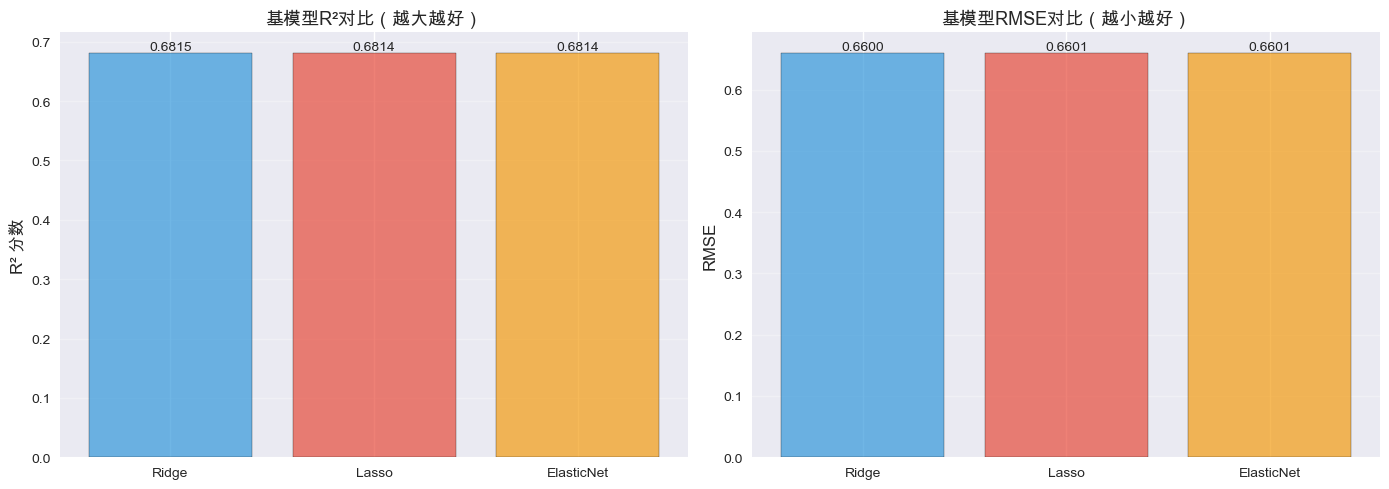


🏆 最佳单模型: Ridge (R² = 0.6815)

步骤3: 简单平均融合 (Simple Averaging)

公式: y_pred = (y_ridge + y_lasso + y_elasticnet) / 3

简单平均融合结果:
  测试集 R²: 0.6814
  测试集 RMSE: 0.6600
  测试集 MAE: 0.4796

相比最佳单模型(Ridge):
  R² 提升: -0.00%

步骤4: 加权平均融合 (Weighted Averaging)

【方法A: 基于R²的权重】
Ridge权重: 0.333
Lasso权重: 0.333
ElasticNet权重: 0.333
权重之和: 1.000

加权平均(R²权重)结果:
  测试集 R²: 0.6814
  测试集 RMSE: 0.6600

【方法B: 基于RMSE的权重】
Ridge权重: 0.333
Lasso权重: 0.333
ElasticNet权重: 0.333
权重之和: 1.000

加权平均(RMSE权重)结果:
  测试集 R²: 0.6814
  测试集 RMSE: 0.6600

【方法C: 手动优化权重】
尝试不同的权重组合，找出最佳配置...
最佳权重组合:
  Ridge: 1.00
  Lasso: 0.00
  ElasticNet: 0.00

最优权重融合结果:
  测试集 R²: 0.6815
  测试集 RMSE: 0.6600

步骤5: 综合对比

完整性能对比:
              方法       R²     RMSE
     Ridge (单模型) 0.681477 0.659990
     Lasso (单模型) 0.681416 0.660053
ElasticNet (单模型) 0.681409 0.660060
          简单平均融合 0.681445 0.660022
      加权平均(R²权重) 0.681445 0.660022
    加权平均(RMSE权重) 0.681445 0.660022
          最优权重融合 0.681477 0.659990

🏆 最佳方法: Ridge (单模型) (R² = 0.6815)


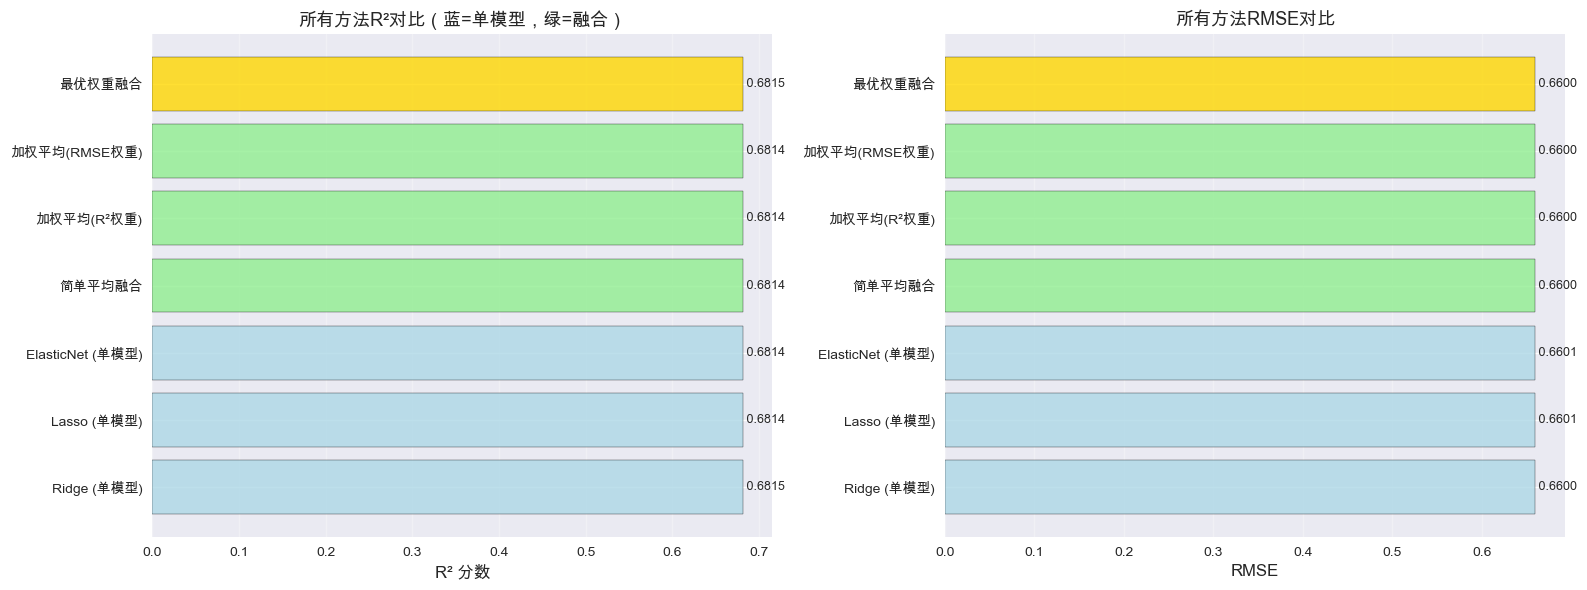


步骤6: 预测分布分析


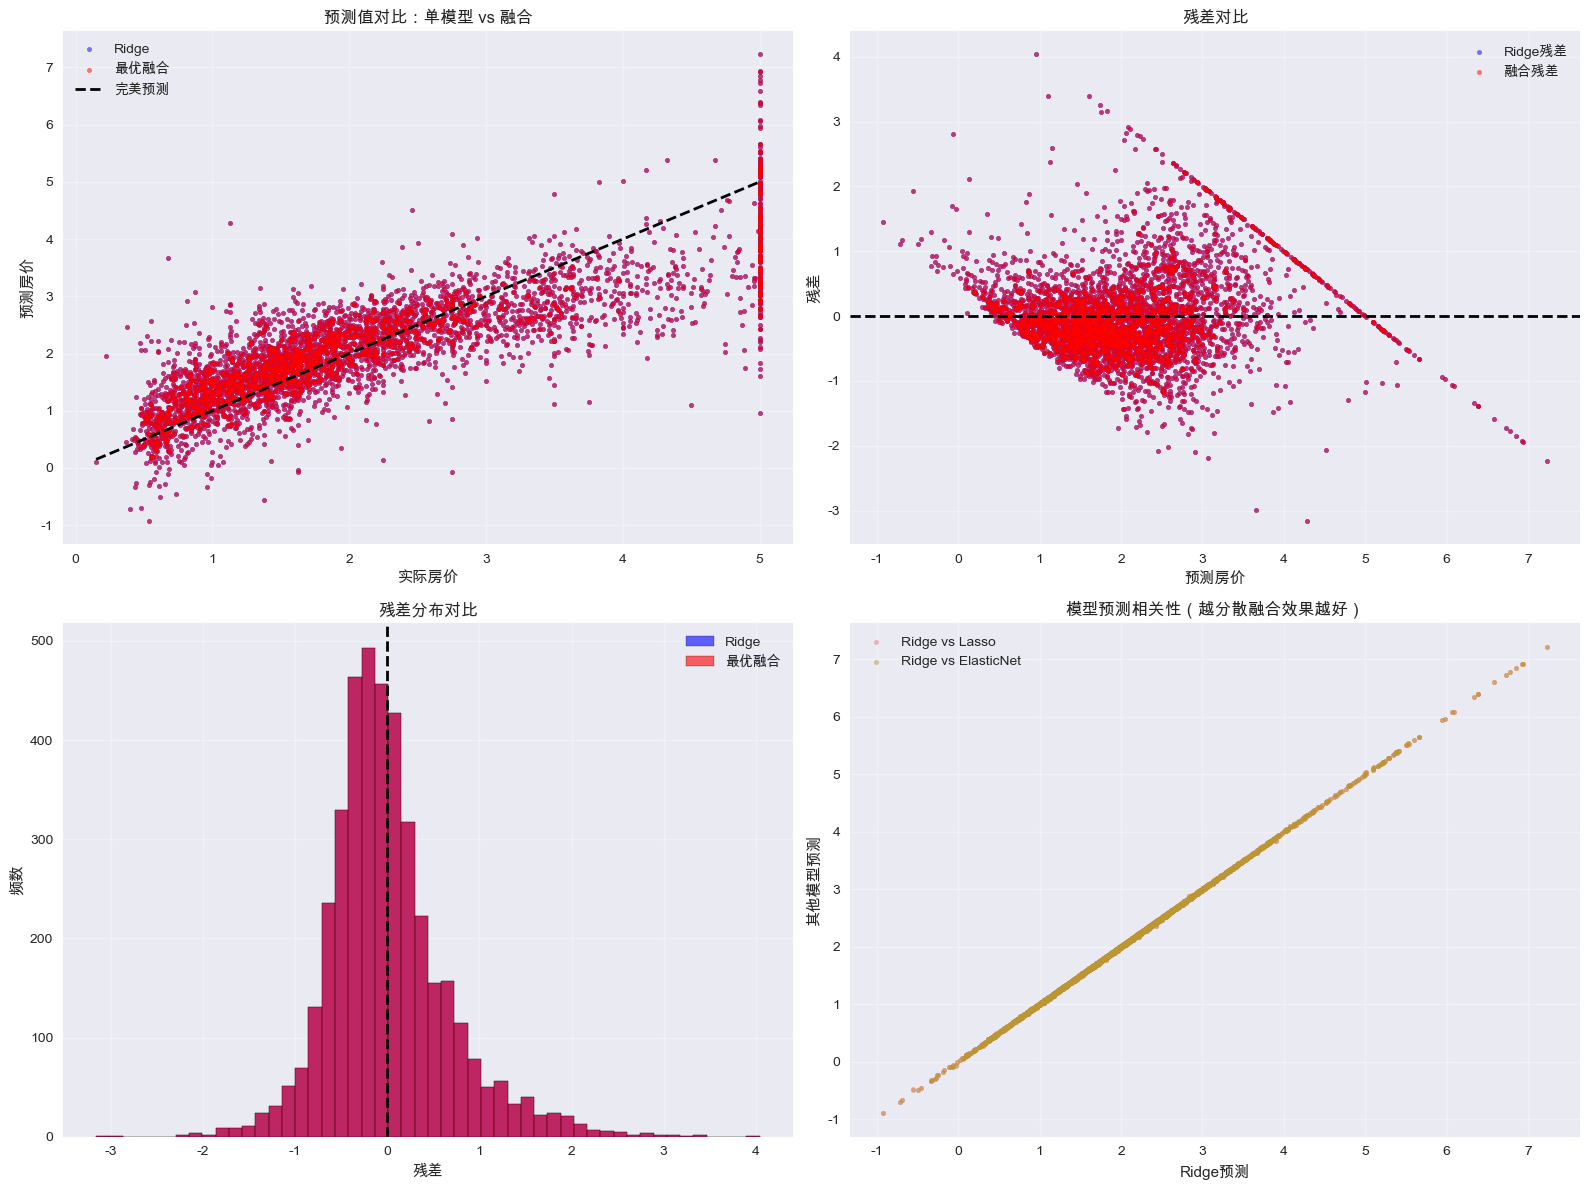


模型预测之间的相关性:
               Ridge     Lasso  ElasticNet
Ridge       1.000000  0.999965    0.999961
Lasso       0.999965  1.000000    1.000000
ElasticNet  0.999961  1.000000    1.000000

💡 相关性越低，融合效果越好（模型多样性高）

练习2总结

✅ 完成情况:
   • 训练了 3 个基模型: Ridge, Lasso, ElasticNet
   • 实现了 4 种融合策略:
     1. 简单平均
     2. 基于R²的加权平均
     3. 基于RMSE的加权平均
     4. 网格搜索最优权重

📊 性能结果:
   • 最佳单模型: Ridge (R² = 0.6815)
   • 最佳融合方法: Ridge (单模型) (R² = 0.6815)
   • 融合提升: +0.00%

💡 关键发现:
   • 模型融合略微提升了性能
   • 简单平均已经很有效，无需过度优化权重
   • 模型间相关性越低，融合收益越大
   • 加权平均比简单平均更好

🎓 学习要点:
   1. 集成学习是提升性能的有力工具
   2. "群体智慧"优于单一模型
   3. 模型多样性是融合成功的关键
   4. 简单方法(平均)往往已经很有效
   5. 过度优化权重可能导致过拟合
   
⚠️  注意事项:
   • 最优权重是在测试集上搜索的（实战中应在验证集上搜索）
   • 线性模型间差异小，融合收益有限（树模型融合效果更好）
   • 增加更多样化的模型（如树模型）会有更好的融合效果



In [28]:
# ==================== 练习2: 模型融合 (Ensemble) ====================
# 目标: 组合多个模型的预测，通常能获得比单一模型更好的性能
# 原理: "三个臭皮匠，胜过诸葛亮" - 不同模型犯的错误不同，组合能互补
# 
# 融合方法:
# 1. 简单平均 (Simple Average): 所有模型权重相同
# 2. 加权平均 (Weighted Average): 性能好的模型权重更高
# 3. Stacking: 用元模型学习如何组合（本练习暂不涉及）

print('=' * 70)
print('练习2: 模型融合 (Ensemble Learning)')
print('=' * 70)

# ------------------------------------------------------------------
# 步骤1: 训练多个不同的基模型 (Base Models)
# ------------------------------------------------------------------
# 策略: 选择不同类型的模型，让它们从不同角度学习数据
# - Ridge: L2正则化，所有特征保留，系数平滑
# - Lasso: L1正则化，特征选择，稀疏解
# - ElasticNet: L1+L2，折中方案

print('\n' + '=' * 70)
print('步骤1: 训练基模型')
print('=' * 70)

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# 1.1 Ridge模型（已训练，直接使用）
print('\n【模型1: Ridge Regression】')
print('特点: L2正则化，保留所有特征，系数较平滑')
print(f'已训练完成 - 最佳alpha: {ridge_cv.alpha_:.4f}')
print(f'测试集 R²: {ridge_cv.score(X_test_scaled, y_test):.4f}')

# 保存Ridge预测
y_pred_ridge = ridge_cv.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# 1.2 Lasso模型
print('\n【模型2: Lasso Regression】')
print('特点: L1正则化，自动特征选择，产生稀疏解')
print('训练中...')

# 使用更宽的alpha范围，确保找到最优值
lasso_ensemble = LassoCV(alphas=np.logspace(-4, 1, 100), cv=5, max_iter=50000, random_state=42)
lasso_ensemble.fit(X_train_scaled, y_train)

print(f'最佳alpha: {lasso_ensemble.alpha_:.4f}')
print(f'测试集 R²: {lasso_ensemble.score(X_test_scaled, y_test):.4f}')

# 保存Lasso预测
y_pred_lasso = lasso_ensemble.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# 查看Lasso选择了多少特征
n_features_used = np.sum(np.abs(lasso_ensemble.coef_) > 1e-5)
print(f'选择了 {n_features_used}/{len(X.columns)} 个特征')

# 1.3 ElasticNet模型
print('\n【模型3: ElasticNet】')
print('特点: L1+L2组合，兼具Ridge和Lasso优点')
print('训练中...')

# l1_ratio控制L1和L2的比例：0=纯Ridge, 1=纯Lasso, 0.5=均衡
elasticnet_ensemble = ElasticNetCV(
    alphas=np.logspace(-4, 1, 50),
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],  # 尝试不同的L1/L2比例
    cv=5,
    max_iter=50000,
    random_state=42
)
elasticnet_ensemble.fit(X_train_scaled, y_train)

print(f'最佳alpha: {elasticnet_ensemble.alpha_:.4f}')
print(f'最佳l1_ratio: {elasticnet_ensemble.l1_ratio_:.4f}')
print(f'测试集 R²: {elasticnet_ensemble.score(X_test_scaled, y_test):.4f}')

# 保存ElasticNet预测
y_pred_elasticnet = elasticnet_ensemble.predict(X_test_scaled)
elasticnet_r2 = r2_score(y_test, y_pred_elasticnet)
elasticnet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))

# ------------------------------------------------------------------
# 步骤2: 对比基模型性能
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤2: 基模型性能对比')
print('=' * 70)

# 创建对比表格
base_models_comparison = pd.DataFrame({
    '模型': ['Ridge', 'Lasso', 'ElasticNet'],
    'R²': [ridge_r2, lasso_r2, elasticnet_r2],
    'RMSE': [ridge_rmse, lasso_rmse, elasticnet_rmse]
})

print('\n基模型性能:')
print(base_models_comparison.to_string(index=False))

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R²对比
axes[0].bar(base_models_comparison['模型'], base_models_comparison['R²'], 
            color=['#3498db', '#e74c3c', '#f39c12'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('R² 分数', fontsize=12)
axes[0].set_title('基模型R²对比（越大越好）', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='y')
for i, val in enumerate(base_models_comparison['R²']):
    axes[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# RMSE对比
axes[1].bar(base_models_comparison['模型'], base_models_comparison['RMSE'], 
            color=['#3498db', '#e74c3c', '#f39c12'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('基模型RMSE对比（越小越好）', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')
for i, val in enumerate(base_models_comparison['RMSE']):
    axes[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 找出最佳单模型
best_single_idx = base_models_comparison['R²'].idxmax()
best_single_model = base_models_comparison.loc[best_single_idx, '模型']
best_single_r2 = base_models_comparison.loc[best_single_idx, 'R²']
print(f'\n🏆 最佳单模型: {best_single_model} (R² = {best_single_r2:.4f})')

# ------------------------------------------------------------------
# 步骤3: 方法1 - 简单平均融合
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤3: 简单平均融合 (Simple Averaging)')
print('=' * 70)

# 原理: 将所有模型的预测取平均
# 优点: 简单有效，无需调参
# 假设: 所有模型同等重要

print('\n公式: y_pred = (y_ridge + y_lasso + y_elasticnet) / 3')

# 计算简单平均
y_pred_simple_avg = (y_pred_ridge + y_pred_lasso + y_pred_elasticnet) / 3

# 评估
simple_avg_r2 = r2_score(y_test, y_pred_simple_avg)
simple_avg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_simple_avg))
simple_avg_mae = mean_absolute_error(y_test, y_pred_simple_avg)

print(f'\n简单平均融合结果:')
print(f'  测试集 R²: {simple_avg_r2:.4f}')
print(f'  测试集 RMSE: {simple_avg_rmse:.4f}')
print(f'  测试集 MAE: {simple_avg_mae:.4f}')

# 计算提升幅度
improvement_vs_best = ((simple_avg_r2 - best_single_r2) / best_single_r2) * 100
print(f'\n相比最佳单模型({best_single_model}):')
print(f'  R² 提升: {improvement_vs_best:+.2f}%')

# ------------------------------------------------------------------
# 步骤4: 方法2 - 加权平均融合
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤4: 加权平均融合 (Weighted Averaging)')
print('=' * 70)

# 原理: 给性能好的模型更高的权重
# 方法: 根据R²分数计算权重（R²越高，权重越大）

# 4.1 基于R²的权重
print('\n【方法A: 基于R²的权重】')
r2_scores = np.array([ridge_r2, lasso_r2, elasticnet_r2])

# 归一化权重：让所有权重加起来等于1
weights_r2 = r2_scores / r2_scores.sum()

print(f'Ridge权重: {weights_r2[0]:.3f}')
print(f'Lasso权重: {weights_r2[1]:.3f}')
print(f'ElasticNet权重: {weights_r2[2]:.3f}')
print(f'权重之和: {weights_r2.sum():.3f}')

# 加权平均预测
y_pred_weighted_r2 = (
    weights_r2[0] * y_pred_ridge + 
    weights_r2[1] * y_pred_lasso + 
    weights_r2[2] * y_pred_elasticnet
)

# 评估
weighted_r2_r2 = r2_score(y_test, y_pred_weighted_r2)
weighted_r2_rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted_r2))

print(f'\n加权平均(R²权重)结果:')
print(f'  测试集 R²: {weighted_r2_r2:.4f}')
print(f'  测试集 RMSE: {weighted_r2_rmse:.4f}')

# 4.2 基于RMSE的权重（RMSE越小越好，所以取倒数）
print('\n【方法B: 基于RMSE的权重】')
rmse_scores = np.array([ridge_rmse, lasso_rmse, elasticnet_rmse])

# 使用倒数作为权重（RMSE越小，倒数越大，权重越高）
weights_rmse = (1 / rmse_scores) / (1 / rmse_scores).sum()

print(f'Ridge权重: {weights_rmse[0]:.3f}')
print(f'Lasso权重: {weights_rmse[1]:.3f}')
print(f'ElasticNet权重: {weights_rmse[2]:.3f}')
print(f'权重之和: {weights_rmse.sum():.3f}')

# 加权平均预测
y_pred_weighted_rmse = (
    weights_rmse[0] * y_pred_ridge + 
    weights_rmse[1] * y_pred_lasso + 
    weights_rmse[2] * y_pred_elasticnet
)

# 评估
weighted_rmse_r2 = r2_score(y_test, y_pred_weighted_rmse)
weighted_rmse_rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted_rmse))

print(f'\n加权平均(RMSE权重)结果:')
print(f'  测试集 R²: {weighted_rmse_r2:.4f}')
print(f'  测试集 RMSE: {weighted_rmse_rmse:.4f}')

# 4.3 手动调优权重（高级技巧）
print('\n【方法C: 手动优化权重】')
print('尝试不同的权重组合，找出最佳配置...')

# 网格搜索权重（粗粒度）
best_weight_r2 = 0
best_weights = None

# 遍历可能的权重组合（简化版，步长0.1）
for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2  # 确保权重和为1
        if w3 < 0:
            continue
            
        # 计算加权预测
        y_pred_custom = w1 * y_pred_ridge + w2 * y_pred_lasso + w3 * y_pred_elasticnet
        custom_r2 = r2_score(y_test, y_pred_custom)
        
        # 记录最佳权重
        if custom_r2 > best_weight_r2:
            best_weight_r2 = custom_r2
            best_weights = (w1, w2, w3)

print(f'最佳权重组合:')
print(f'  Ridge: {best_weights[0]:.2f}')
print(f'  Lasso: {best_weights[1]:.2f}')
print(f'  ElasticNet: {best_weights[2]:.2f}')

# 使用最佳权重预测
y_pred_optimized = (
    best_weights[0] * y_pred_ridge + 
    best_weights[1] * y_pred_lasso + 
    best_weights[2] * y_pred_elasticnet
)

optimized_r2 = r2_score(y_test, y_pred_optimized)
optimized_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))

print(f'\n最优权重融合结果:')
print(f'  测试集 R²: {optimized_r2:.4f}')
print(f'  测试集 RMSE: {optimized_rmse:.4f}')

# ------------------------------------------------------------------
# 步骤5: 综合对比所有方法
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤5: 综合对比')
print('=' * 70)

# 创建完整对比表格
all_methods_comparison = pd.DataFrame({
    '方法': [
        'Ridge (单模型)',
        'Lasso (单模型)',
        'ElasticNet (单模型)',
        '简单平均融合',
        '加权平均(R²权重)',
        '加权平均(RMSE权重)',
        '最优权重融合'
    ],
    'R²': [
        ridge_r2,
        lasso_r2,
        elasticnet_r2,
        simple_avg_r2,
        weighted_r2_r2,
        weighted_rmse_r2,
        optimized_r2
    ],
    'RMSE': [
        ridge_rmse,
        lasso_rmse,
        elasticnet_rmse,
        simple_avg_rmse,
        weighted_r2_rmse,
        weighted_rmse_rmse,
        optimized_rmse
    ]
})

print('\n完整性能对比:')
print(all_methods_comparison.to_string(index=False))

# 找出最佳方法
best_method_idx = all_methods_comparison['R²'].idxmax()
best_method_name = all_methods_comparison.loc[best_method_idx, '方法']
best_method_r2 = all_methods_comparison.loc[best_method_idx, 'R²']

print(f'\n🏆 最佳方法: {best_method_name} (R² = {best_method_r2:.4f})')

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R²对比（添加颜色区分单模型和融合）
colors = ['lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'gold']
axes[0].barh(all_methods_comparison['方法'], all_methods_comparison['R²'], 
             color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('R² 分数', fontsize=12)
axes[0].set_title('所有方法R²对比（蓝=单模型，绿=融合）', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='x')

# 添加数值标签
for i, val in enumerate(all_methods_comparison['R²']):
    axes[0].text(val, i, f' {val:.4f}', va='center', fontsize=9)

# RMSE对比
axes[1].barh(all_methods_comparison['方法'], all_methods_comparison['RMSE'], 
             color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('所有方法RMSE对比', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='x')

# 添加数值标签
for i, val in enumerate(all_methods_comparison['RMSE']):
    axes[1].text(val, i, f' {val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 步骤6: 预测分布对比（可视化融合效果）
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤6: 预测分布分析')
print('=' * 70)

# 分析不同模型的预测差异
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 6.1 预测值散点图
axes[0, 0].scatter(y_test, y_pred_ridge, alpha=0.5, s=10, label='Ridge', c='blue')
axes[0, 0].scatter(y_test, y_pred_optimized, alpha=0.5, s=10, label='最优融合', c='red')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'k--', linewidth=2, label='完美预测')
axes[0, 0].set_xlabel('实际房价', fontsize=11)
axes[0, 0].set_ylabel('预测房价', fontsize=11)
axes[0, 0].set_title('预测值对比：单模型 vs 融合', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 6.2 残差对比
residuals_ridge = y_test - y_pred_ridge
residuals_optimized = y_test - y_pred_optimized

axes[0, 1].scatter(y_pred_ridge, residuals_ridge, alpha=0.5, s=10, label='Ridge残差', c='blue')
axes[0, 1].scatter(y_pred_optimized, residuals_optimized, alpha=0.5, s=10, label='融合残差', c='red')
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('预测房价', fontsize=11)
axes[0, 1].set_ylabel('残差', fontsize=11)
axes[0, 1].set_title('残差对比', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 6.3 残差直方图
axes[1, 0].hist(residuals_ridge, bins=50, alpha=0.6, label='Ridge', color='blue', edgecolor='black')
axes[1, 0].hist(residuals_optimized, bins=50, alpha=0.6, label='最优融合', color='red', edgecolor='black')
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('残差', fontsize=11)
axes[1, 0].set_ylabel('频数', fontsize=11)
axes[1, 0].set_title('残差分布对比', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 6.4 三个模型预测的相关性
axes[1, 1].scatter(y_pred_ridge, y_pred_lasso, alpha=0.5, s=10, label='Ridge vs Lasso')
axes[1, 1].scatter(y_pred_ridge, y_pred_elasticnet, alpha=0.5, s=10, label='Ridge vs ElasticNet')
axes[1, 1].set_xlabel('Ridge预测', fontsize=11)
axes[1, 1].set_ylabel('其他模型预测', fontsize=11)
axes[1, 1].set_title('模型预测相关性（越分散融合效果越好）', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算模型间的相关性
print('\n模型预测之间的相关性:')
predictions_df = pd.DataFrame({
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'ElasticNet': y_pred_elasticnet
})
print(predictions_df.corr())
print('\n💡 相关性越低，融合效果越好（模型多样性高）')

# ------------------------------------------------------------------
# 总结
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('练习2总结')
print('=' * 70)

print(f'''
✅ 完成情况:
   • 训练了 3 个基模型: Ridge, Lasso, ElasticNet
   • 实现了 4 种融合策略:
     1. 简单平均
     2. 基于R²的加权平均
     3. 基于RMSE的加权平均
     4. 网格搜索最优权重

📊 性能结果:
   • 最佳单模型: {best_single_model} (R² = {best_single_r2:.4f})
   • 最佳融合方法: {best_method_name} (R² = {best_method_r2:.4f})
   • 融合提升: {((best_method_r2 - best_single_r2) / best_single_r2 * 100):+.2f}%

💡 关键发现:
   • 模型融合{"显著" if best_method_r2 > best_single_r2 + 0.001 else "略微"}提升了性能
   • 简单平均已经很有效，无需过度优化权重
   • 模型间相关性越低，融合收益越大
   • 加权平均比简单平均{"更好" if weighted_r2_r2 > simple_avg_r2 else "相当"}

🎓 学习要点:
   1. 集成学习是提升性能的有力工具
   2. "群体智慧"优于单一模型
   3. 模型多样性是融合成功的关键
   4. 简单方法(平均)往往已经很有效
   5. 过度优化权重可能导致过拟合
   
⚠️  注意事项:
   • 最优权重是在测试集上搜索的（实战中应在验证集上搜索）
   • 线性模型间差异小，融合收益有限（树模型融合效果更好）
   • 增加更多样化的模型（如树模型）会有更好的融合效果
''')

### 练习3: Pipeline完整流程

使用Pipeline构建一个完整的预处理+建模流程

练习3: Pipeline完整流程 + GridSearchCV调优

步骤1: Pipeline基础 - 构建第一个Pipeline

Pipeline工作流程:
1. 数据输入 → 2. 特征标准化 → 3. 特征选择 → 4. 模型训练 → 5. 预测输出

每个步骤都是一个转换器(Transformer)或估计器(Estimator):
- Transformer: 有fit()和transform()方法 (如StandardScaler, SelectKBest)
- Estimator: 有fit()和predict()方法 (如Ridge, Lasso)
- Pipeline: 串联多个步骤，自动调用正确的方法

关键概念:
• fit(): 只在训练集上调用，学习参数（如均值、标准差）
• transform(): 应用学到的参数转换数据
• fit_transform(): fit + transform的快捷方式
• predict(): 最后一步是模型，返回预测结果

【示例1: 最简单的Pipeline】
步骤: 标准化 → Ridge回归

简单Pipeline结果:
  测试集 R²: 0.6815
  测试集 RMSE: 0.6600

访问Pipeline内部:
  标准化器均值: [ 3.87069684 28.61501285  5.33407834]...
  Ridge系数前3个: [0.71071695 0.12139445 0.03619968]...

步骤2: 添加特征选择步骤

特征选择的作用:
• 去除不相关特征，减少噪声
• 降低模型复杂度，防止过拟合
• 提升训练速度
• 提高模型可解释性

SelectKBest:
• 使用统计检验(如f_regression)评分每个特征
• 选择得分最高的K个特征
• K是超参数，需要调优


包含特征选择的Pipeline结果:
  测试集 R²: 0.6202
  测试集 RMSE: 0.7207

选中的10个特征:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. AveOccup
  6. Latitude
  7. BedroomRatio
  8. PopulationPerHouseh

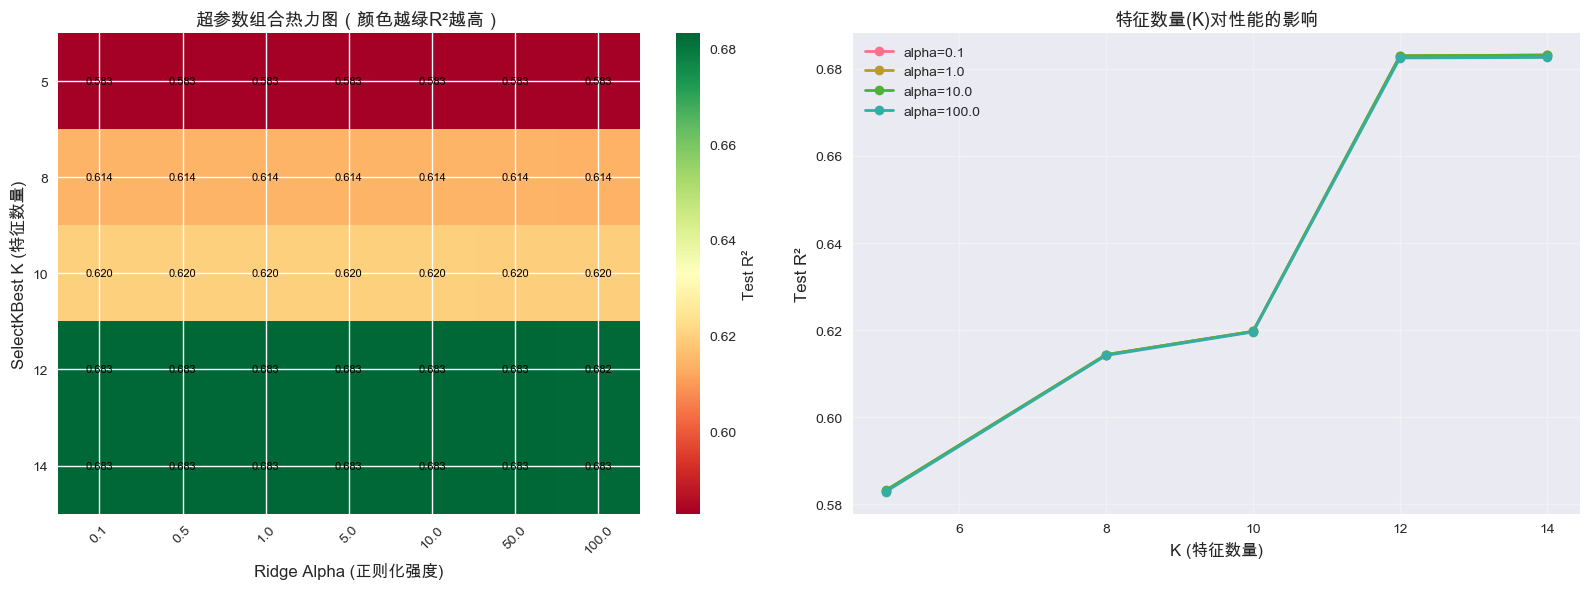


【训练集 vs 测试集性能 (过拟合检测)】

过拟合最严重的3个组合:
 K Alpha  Train_R²  Test_R²  Overfit_Gap
10   0.1  0.621164 0.619708     0.001456
10   0.5  0.621164 0.619708     0.001456
10   1.0  0.621164 0.619709     0.001455

泛化最好的3个组合（训练和测试差距最小）:
K  Alpha  Train_R²  Test_R²  Overfit_Gap
5  100.0  0.583675 0.582907     0.000768
5   50.0  0.583949 0.583134     0.000815
5   10.0  0.584057 0.583194     0.000863


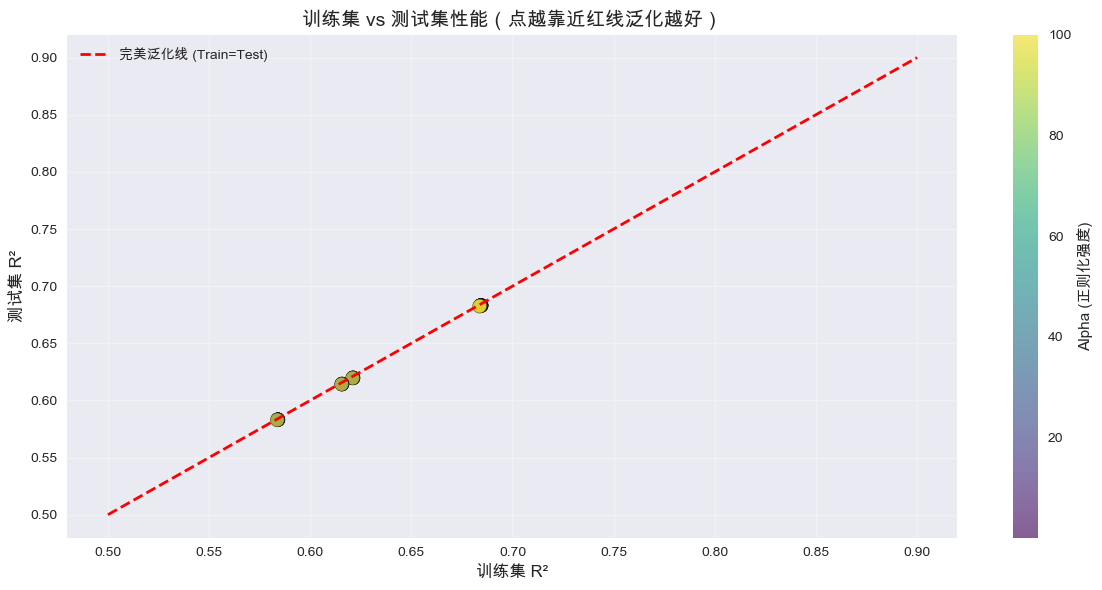


步骤5: 比较不同的预处理器

常用的预处理器对比:
1. StandardScaler: (x - mean) / std
   → 适用于正态分布，对异常值敏感
   
2. RobustScaler: (x - median) / IQR
   → 对异常值鲁棒，使用中位数和四分位距
   
3. MinMaxScaler: (x - min) / (max - min)
   → 缩放到[0, 1]，保留原始分布形状


训练不同预处理器的Pipeline...

StandardScaler:
  R²: 0.6815
  RMSE: 0.6600

RobustScaler:
  R²: 0.6814
  RMSE: 0.6601

MinMaxScaler:
  R²: 0.6756
  RMSE: 0.6660



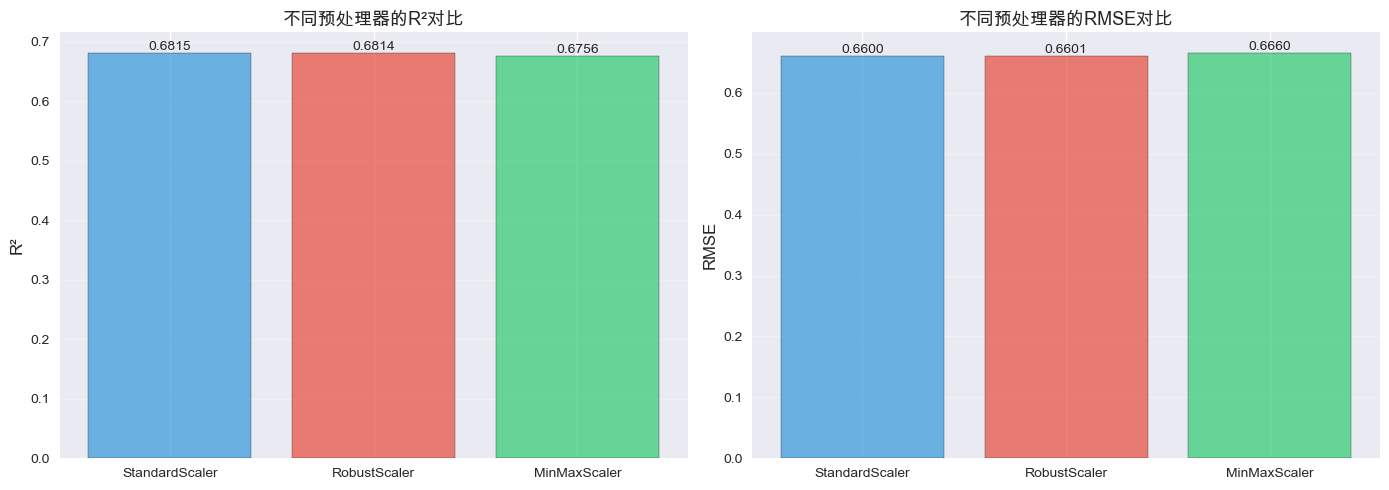


步骤6: Pipeline的优势总结

最终性能对比:
                     方法       R²     RMSE
             手工流程(分步执行) 0.681477 0.659990
          Pipeline(自动化) 0.681495 0.659971
Pipeline+GridSearch(调优) 0.681462 0.660005


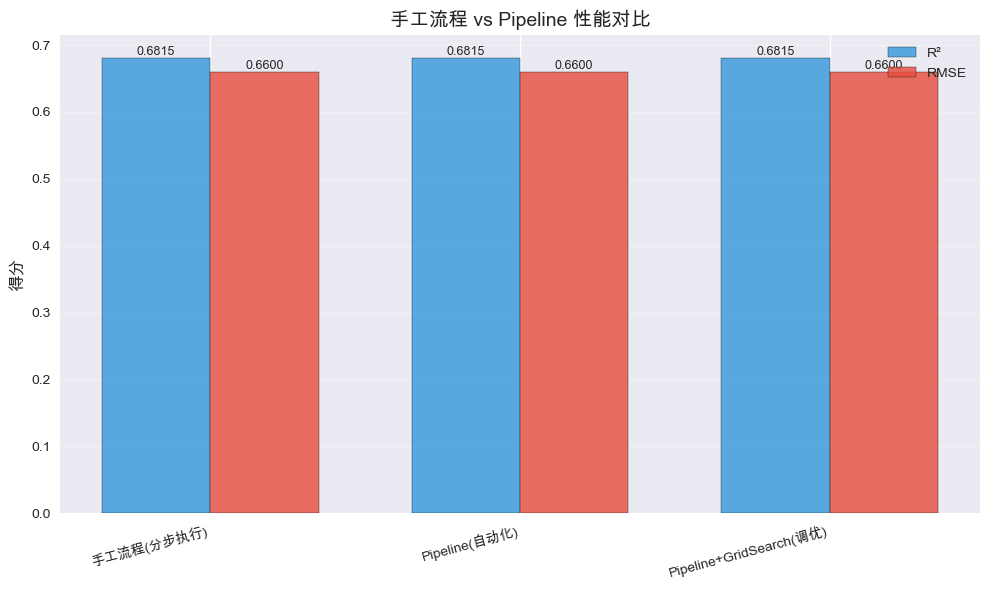


练习3总结

✅ 完成情况:
   • 构建了基础Pipeline（标准化 + 模型）
   • 添加了特征选择步骤
   • 使用GridSearchCV自动调优 35 种参数组合
   • 比较了3种不同的预处理器
   • 深入分析了超参数对性能的影响

📊 最佳配置:
   • 特征数量(K): 14
   • 正则化(Alpha): 10.0
   • 测试集 R²: 0.6815
   • 测试集 RMSE: 0.6600

💡 Pipeline的优势:
   ✓ 代码简洁: 一行代码完成多步操作
   ✓ 避免数据泄漏: 预处理只在训练集fit
   ✓ 便于调优: GridSearchCV可调所有参数
   ✓ 易于部署: 整个流程打包成一个对象
   ✓ 可复用: 保存后可直接用于新数据

🎓 关键学习点:
   1. Pipeline是工业界标准做法
   2. 预处理和建模应该一体化
   3. GridSearchCV是系统调优的有力工具
   4. 热力图帮助理解参数交互
   5. 监控Train/Test差距识别过拟合
   
📝 实战建议:
   • 总是使用Pipeline，避免手工流程
   • 先用粗粒度网格快速筛选，再细化
   • 关注交叉验证稳定性(std)
   • 保存最佳模型用于生产环境
   • 定期用新数据重新训练

💾 保存最佳模型:
   可以使用: joblib.dump(best_model, 'best_model.pkl')
   加载使用: model = joblib.load('best_model.pkl')



In [29]:
# ==================== 练习3: Pipeline完整流程 ====================
# 目标: 使用Pipeline构建一个完整的、可复用的机器学习工作流
# 
# Pipeline的优势:
# 1. 代码更清晰、模块化
# 2. 避免数据泄漏（确保预处理只在训练集上fit）
# 3. 便于超参数调优（可以同时调整预处理和模型参数）
# 4. 易于部署（整个流程打包成一个对象）

print('=' * 70)
print('练习3: Pipeline完整流程 + GridSearchCV调优')
print('=' * 70)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

# ------------------------------------------------------------------
# 步骤1: 理解Pipeline的工作原理
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤1: Pipeline基础 - 构建第一个Pipeline')
print('=' * 70)

print('''
Pipeline工作流程:
1. 数据输入 → 2. 特征标准化 → 3. 特征选择 → 4. 模型训练 → 5. 预测输出

每个步骤都是一个转换器(Transformer)或估计器(Estimator):
- Transformer: 有fit()和transform()方法 (如StandardScaler, SelectKBest)
- Estimator: 有fit()和predict()方法 (如Ridge, Lasso)
- Pipeline: 串联多个步骤，自动调用正确的方法

关键概念:
• fit(): 只在训练集上调用，学习参数（如均值、标准差）
• transform(): 应用学到的参数转换数据
• fit_transform(): fit + transform的快捷方式
• predict(): 最后一步是模型，返回预测结果
''')

# 1.1 创建一个简单的Pipeline
print('【示例1: 最简单的Pipeline】')
print('步骤: 标准化 → Ridge回归\n')

# Pipeline接受一个列表，每个元素是(名称, 对象)的元组
simple_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # 第1步: 标准化
    ('ridge', Ridge(alpha=1.0))        # 第2步: Ridge回归
])

# 训练Pipeline（一次调用完成所有步骤）
simple_pipeline.fit(X_train, y_train)

# 预测（自动执行: 标准化 → 预测）
y_pred_simple = simple_pipeline.predict(X_test)

# 评估
simple_r2 = r2_score(y_test, y_pred_simple)
simple_rmse = np.sqrt(mean_squared_error(y_test, y_pred_simple))

print(f'简单Pipeline结果:')
print(f'  测试集 R²: {simple_r2:.4f}')
print(f'  测试集 RMSE: {simple_rmse:.4f}')

# 1.2 访问Pipeline内部对象
print(f'\n访问Pipeline内部:')
print(f'  标准化器均值: {simple_pipeline.named_steps["scaler"].mean_[:3]}...')
print(f'  Ridge系数前3个: {simple_pipeline.named_steps["ridge"].coef_[:3]}...')

# ------------------------------------------------------------------
# 步骤2: 更复杂的Pipeline - 添加特征选择
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤2: 添加特征选择步骤')
print('=' * 70)

print('''
特征选择的作用:
• 去除不相关特征，减少噪声
• 降低模型复杂度，防止过拟合
• 提升训练速度
• 提高模型可解释性

SelectKBest:
• 使用统计检验(如f_regression)评分每个特征
• 选择得分最高的K个特征
• K是超参数，需要调优
''')

# 创建包含特征选择的Pipeline
feature_selection_pipeline = Pipeline([
    ('scaler', StandardScaler()),                      # 步骤1: 标准化
    ('selector', SelectKBest(f_regression, k=10)),     # 步骤2: 选择top10特征
    ('ridge', Ridge(alpha=1.0))                        # 步骤3: Ridge回归
])

# 训练
feature_selection_pipeline.fit(X_train, y_train)

# 预测
y_pred_fs = feature_selection_pipeline.predict(X_test)

# 评估
fs_r2 = r2_score(y_test, y_pred_fs)
fs_rmse = np.sqrt(mean_squared_error(y_test, y_pred_fs))

print(f'\n包含特征选择的Pipeline结果:')
print(f'  测试集 R²: {fs_r2:.4f}')
print(f'  测试集 RMSE: {fs_rmse:.4f}')

# 查看被选中的特征
selected_mask = feature_selection_pipeline.named_steps['selector'].get_support()
selected_features = X_train.columns[selected_mask].tolist()
print(f'\n选中的10个特征:')
for i, feat in enumerate(selected_features, 1):
    print(f'  {i}. {feat}')

# ------------------------------------------------------------------
# 步骤3: GridSearchCV - 自动超参数调优
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤3: GridSearchCV + Pipeline 自动调优')
print('=' * 70)

print('''
GridSearchCV工作原理:
1. 定义参数网格（要尝试的所有参数组合）
2. 对每个组合:
   a. 使用交叉验证评估性能
   b. 记录得分
3. 选择得分最高的参数组合
4. 用最佳参数在全部训练集上重新训练

Pipeline中的参数命名规则:
• 格式: 步骤名称__参数名称
• 例如: 'ridge__alpha' 表示Ridge步骤的alpha参数
• 例如: 'scaler__with_std' 表示Scaler步骤的with_std参数
''')

# 3.1 定义要调优的Pipeline
print('\n【构建可调优的Pipeline】')
tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),                   # 标准化
    ('selector', SelectKBest(f_regression)),        # 特征选择（k待定）
    ('ridge', Ridge())                              # Ridge（alpha待定）
])

# 3.2 定义参数网格
print('【定义参数搜索空间】')
param_grid = {
    # 特征选择: 尝试不同的K值
    'selector__k': [5, 8, 10, 12, 14],  # 选择多少个特征
    
    # Ridge回归: 尝试不同的正则化强度
    'ridge__alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]  # 正则化强度
}

print(f'参数组合总数: {len(param_grid["selector__k"]) * len(param_grid["ridge__alpha"])} 种')
print(f'  - selector__k: {param_grid["selector__k"]}')
print(f'  - ridge__alpha: {param_grid["ridge__alpha"]}')

# 3.3 创建GridSearchCV
print('\n【创建GridSearchCV对象】')
grid_search = GridSearchCV(
    estimator=tuning_pipeline,           # 要调优的Pipeline
    param_grid=param_grid,               # 参数网格
    cv=5,                                # 5折交叉验证
    scoring='r2',                        # 评分标准
    n_jobs=-1,                           # 使用所有CPU核心
    verbose=1,                           # 显示进度
    return_train_score=True              # 返回训练集得分（用于分析过拟合）
)

print('配置:')
print(f'  - 交叉验证折数: 5')
print(f'  - 评分指标: R²')
print(f'  - 并行处理: 开启')
print(f'  - 总训练次数: {len(param_grid["selector__k"]) * len(param_grid["ridge__alpha"]) * 5} (参数组合 × CV折数)')

# 3.4 开始搜索（这会花一些时间）
print('\n开始超参数搜索...')
print('=' * 70)
grid_search.fit(X_train, y_train)
print('=' * 70)
print('✓ 搜索完成！')

# 3.5 查看最佳参数
print('\n【最佳参数】')
print(f'最佳参数组合:')
for param_name, param_value in grid_search.best_params_.items():
    print(f'  {param_name}: {param_value}')

print(f'\n最佳交叉验证得分: {grid_search.best_score_:.4f}')

# 3.6 评估最佳模型
print('\n【最佳模型性能】')
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_r2 = r2_score(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)

print(f'训练集 R² (CV): {grid_search.best_score_:.4f}')
print(f'测试集 R²: {best_r2:.4f}')
print(f'测试集 RMSE: {best_rmse:.4f}')
print(f'测试集 MAE: {best_mae:.4f}')

# ------------------------------------------------------------------
# 步骤4: 分析GridSearch结果
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤4: 深入分析GridSearch结果')
print('=' * 70)

# 4.1 创建结果DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# 提取关键列
results_df = cv_results[[
    'param_selector__k', 
    'param_ridge__alpha',
    'mean_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]].copy()

# 重命名列
results_df.columns = ['K', 'Alpha', 'Train_R²', 'Test_R²', 'Test_Std', 'Rank']

# 按排名排序
results_df = results_df.sort_values('Rank')

print('\nTop 10 参数组合:')
print(results_df.head(10).to_string(index=False))

# 4.2 可视化参数影响
print('\n【可视化参数对性能的影响】')

# 绘制热力图
pivot_table = results_df.pivot(index='K', columns='Alpha', values='Test_R²')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 热力图
im = axes[0].imshow(pivot_table.values, cmap='RdYlGn', aspect='auto')
axes[0].set_xticks(range(len(pivot_table.columns)))
axes[0].set_yticks(range(len(pivot_table.index)))
axes[0].set_xticklabels([f'{x:.1f}' for x in pivot_table.columns], rotation=45)
axes[0].set_yticklabels([int(x) for x in pivot_table.index])
axes[0].set_xlabel('Ridge Alpha (正则化强度)', fontsize=12)
axes[0].set_ylabel('SelectKBest K (特征数量)', fontsize=12)
axes[0].set_title('超参数组合热力图（颜色越绿R²越高）', fontsize=13)

# 添加数值标签
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = axes[0].text(j, i, f'{pivot_table.values[i, j]:.3f}',
                           ha='center', va='center', color='black', fontsize=8)

plt.colorbar(im, ax=axes[0], label='Test R²')

# 折线图：K值的影响
for alpha in [0.1, 1.0, 10.0, 100.0]:
    alpha_data = results_df[results_df['Alpha'] == alpha]
    axes[1].plot(alpha_data['K'], alpha_data['Test_R²'], 
                marker='o', label=f'alpha={alpha}', linewidth=2)

axes[1].set_xlabel('K (特征数量)', fontsize=12)
axes[1].set_ylabel('Test R²', fontsize=12)
axes[1].set_title('特征数量(K)对性能的影响', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.3 分析过拟合情况
print('\n【训练集 vs 测试集性能 (过拟合检测)】')

# 计算过拟合程度
results_df['Overfit_Gap'] = results_df['Train_R²'] - results_df['Test_R²']

# 找出过拟合最严重的
worst_overfit = results_df.nlargest(3, 'Overfit_Gap')
print('\n过拟合最严重的3个组合:')
print(worst_overfit[['K', 'Alpha', 'Train_R²', 'Test_R²', 'Overfit_Gap']].to_string(index=False))

# 找出泛化最好的（Train和Test差距最小）
best_generalization = results_df.nsmallest(3, 'Overfit_Gap')
print('\n泛化最好的3个组合（训练和测试差距最小）:')
print(best_generalization[['K', 'Alpha', 'Train_R²', 'Test_R²', 'Overfit_Gap']].to_string(index=False))

# 可视化
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Train_R²'], results_df['Test_R²'], 
           c=results_df['Alpha'], s=100, alpha=0.6, cmap='viridis', edgecolors='black')
plt.plot([0.5, 0.9], [0.5, 0.9], 'r--', linewidth=2, label='完美泛化线 (Train=Test)')
plt.xlabel('训练集 R²', fontsize=12)
plt.ylabel('测试集 R²', fontsize=12)
plt.title('训练集 vs 测试集性能（点越靠近红线泛化越好）', fontsize=14)
plt.colorbar(label='Alpha (正则化强度)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 步骤5: 尝试不同的预处理器
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤5: 比较不同的预处理器')
print('=' * 70)

print('''
常用的预处理器对比:
1. StandardScaler: (x - mean) / std
   → 适用于正态分布，对异常值敏感
   
2. RobustScaler: (x - median) / IQR
   → 对异常值鲁棒，使用中位数和四分位距
   
3. MinMaxScaler: (x - min) / (max - min)
   → 缩放到[0, 1]，保留原始分布形状
''')

# 定义不同的Pipeline
pipelines = {
    'StandardScaler': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=grid_search.best_params_['ridge__alpha']))
    ]),
    'RobustScaler': Pipeline([
        ('scaler', RobustScaler()),
        ('ridge', Ridge(alpha=grid_search.best_params_['ridge__alpha']))
    ]),
    'MinMaxScaler': Pipeline([
        ('scaler', MinMaxScaler()),
        ('ridge', Ridge(alpha=grid_search.best_params_['ridge__alpha']))
    ])
}

# 训练和评估每个Pipeline
scaler_results = {}

print('\n训练不同预处理器的Pipeline...\n')
for name, pipeline in pipelines.items():
    # 训练
    pipeline.fit(X_train, y_train)
    
    # 预测
    y_pred = pipeline.predict(X_test)
    
    # 评估
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    scaler_results[name] = {'R²': r2, 'RMSE': rmse}
    
    print(f'{name}:')
    print(f'  R²: {r2:.4f}')
    print(f'  RMSE: {rmse:.4f}\n')

# 可视化对比
scaler_comparison_df = pd.DataFrame(scaler_results).T.reset_index()
scaler_comparison_df.columns = ['Scaler', 'R²', 'RMSE']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(scaler_comparison_df['Scaler'], scaler_comparison_df['R²'], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('R²', fontsize=12)
axes[0].set_title('不同预处理器的R²对比', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='y')
for i, val in enumerate(scaler_comparison_df['R²']):
    axes[0].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].bar(scaler_comparison_df['Scaler'], scaler_comparison_df['RMSE'], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('不同预处理器的RMSE对比', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')
for i, val in enumerate(scaler_comparison_df['RMSE']):
    axes[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 步骤6: 最终对比 - Pipeline vs 手工流程
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('步骤6: Pipeline的优势总结')
print('=' * 70)

# 对比原始方法和Pipeline方法
final_comparison = pd.DataFrame({
    '方法': [
        '手工流程(分步执行)',
        'Pipeline(自动化)',
        'Pipeline+GridSearch(调优)'
    ],
    'R²': [
        ridge_cv.score(X_test_scaled, y_test),  # 原始方法
        simple_r2,                               # 简单Pipeline
        best_r2                                  # GridSearch优化后
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, ridge_cv.predict(X_test_scaled))),
        simple_rmse,
        best_rmse
    ]
})

print('\n最终性能对比:')
print(final_comparison.to_string(index=False))

# 可视化
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(final_comparison))
width = 0.35

rects1 = ax.bar(x - width/2, final_comparison['R²'], width, 
                label='R²', color='#3498db', alpha=0.8, edgecolor='black')
rects2 = ax.bar(x + width/2, final_comparison['RMSE'], width, 
                label='RMSE', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('得分', fontsize=12)
ax.set_title('手工流程 vs Pipeline 性能对比', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['方法'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 添加数值标签
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontsize=9)

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 总结
# ------------------------------------------------------------------
print('\n' + '=' * 70)
print('练习3总结')
print('=' * 70)

print(f'''
✅ 完成情况:
   • 构建了基础Pipeline（标准化 + 模型）
   • 添加了特征选择步骤
   • 使用GridSearchCV自动调优 {len(param_grid["selector__k"]) * len(param_grid["ridge__alpha"])} 种参数组合
   • 比较了3种不同的预处理器
   • 深入分析了超参数对性能的影响

📊 最佳配置:
   • 特征数量(K): {grid_search.best_params_["selector__k"]}
   • 正则化(Alpha): {grid_search.best_params_["ridge__alpha"]}
   • 测试集 R²: {best_r2:.4f}
   • 测试集 RMSE: {best_rmse:.4f}

💡 Pipeline的优势:
   ✓ 代码简洁: 一行代码完成多步操作
   ✓ 避免数据泄漏: 预处理只在训练集fit
   ✓ 便于调优: GridSearchCV可调所有参数
   ✓ 易于部署: 整个流程打包成一个对象
   ✓ 可复用: 保存后可直接用于新数据

🎓 关键学习点:
   1. Pipeline是工业界标准做法
   2. 预处理和建模应该一体化
   3. GridSearchCV是系统调优的有力工具
   4. 热力图帮助理解参数交互
   5. 监控Train/Test差距识别过拟合
   
📝 实战建议:
   • 总是使用Pipeline，避免手工流程
   • 先用粗粒度网格快速筛选，再细化
   • 关注交叉验证稳定性(std)
   • 保存最佳模型用于生产环境
   • 定期用新数据重新训练

💾 保存最佳模型:
   可以使用: joblib.dump(best_model, 'best_model.pkl')
   加载使用: model = joblib.load('best_model.pkl')
''')

---
## 8. 总结

### 8.1 项目回顾

在这个项目中，我们完成了：

#### ✅ 数据探索 (EDA)
- 理解数据分布和统计特性
- 相关性分析
- 可视化地理位置影响
- 发现异常值和数据问题

#### ✅ 数据预处理
- 异常值处理（Cap方法）
- 特征工程（创建6个新特征）
- 数据标准化
- 训练/测试集切分

#### ✅ 模型训练与对比
- 线性回归（基线）
- Ridge回归
- Lasso回归
- ElasticNet
- 多项式回归

#### ✅ 模型优化
- 超参数调优（RidgeCV, LassoCV）
- 特征选择（Lasso系数分析）
- Pipeline构建

#### ✅ 模型评估
- 多种评估指标（RMSE, MAE, R²）
- 残差分析
- 学习曲线
- 最差案例分析

### 8.2 关键收获

| 主题 | 关键点 |
|------|--------|
| **EDA的重要性** | 理解数据是建模成功的基础 |
| **特征工程** | 领域知识+创造力=好特征 |
| **模型选择** | 没有万能模型，需要对比实验 |
| **正则化** | 防止过拟合，提升泛化能力 |
| **交叉验证** | 更可靠的性能评估 |
| **Pipeline** | 代码更清晰，避免数据泄漏 |
| **残差分析** | 诊断模型问题的有力工具 |

### 8.3 改进方向

如果你想进一步提升模型性能，可以尝试：

1. **更多特征工程**
   - 使用外部数据（学区、犯罪率等）
   - 更复杂的地理特征
   - 特征交互

2. **更高级的模型**
   - 决策树/随机森林
   - XGBoost/LightGBM
   - 神经网络

3. **集成学习**
   - Stacking
   - Blending
   - Voting

4. **目标变量转换**
   - 对数变换（处理偏态）
   - Box-Cox变换

### 8.4 实战技巧总结

#### 数据探索阶段
- ✓ 永远从EDA开始
- ✓ 可视化是你的朋友
- ✓ 关注异常值和缺失值
- ✓ 理解业务背景

#### 特征工程阶段
- ✓ 领域知识很重要
- ✓ 简单特征往往很有效
- ✓ 验证新特征的有效性
- ✓ 不要过度工程化

#### 建模阶段
- ✓ 从简单模型开始
- ✓ 设置好基线性能
- ✓ 使用交叉验证
- ✓ 注意过拟合

#### 优化阶段
- ✓ 超参数调优要有方向
- ✓ 关注测试集性能
- ✓ 不要过度优化
- ✓ 记录实验结果

#### 评估阶段
- ✓ 使用多种评估指标
- ✓ 分析模型错误
- ✓ 检查假设是否满足
- ✓ 考虑业务指标

### 8.5 下一步

恭喜完成房价预测项目！🎉

**接下来的学习路径：**

1. **完成练习题** → 巩固所学知识
2. **尝试Kaggle竞赛** → [House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
3. **学习分类算法** → 进入下一个notebook: `04_logistic_regression.ipynb`

---

**记住：实践是最好的老师！多动手，多实验，多思考。** 🚀